# 测试

## 加载模型

In [1]:
import torch
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
modelpath = os.getcwd() + '/dcformer28b'
print("模型所在路径位置: ", modelpath)
sys.path.append(modelpath)

模型所在路径位置:  /root/autodl-tmp/dcformer/dcformer28b


In [2]:
tokenizer = AutoTokenizer.from_pretrained("dcformer28b", padding=True, truncation=True, max_length=500)
model = AutoModelForCausalLM.from_pretrained("/root/autodl-tmp/dcformer/dcformer28b", trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [3]:
device = torch.device('cuda')
device_ = torch.device('cpu')
MAX_BATCH_SIZE = 1
MAX_SEQ_LENGTH = 2048
NUM_TOKENS_TO_GENERATE = 100
COMPILE = True

_ = model.to(device=device, dtype=torch.float16)
with torch.device(device):
    model.setup_caches(max_batch_size=MAX_BATCH_SIZE, max_seq_length=MAX_SEQ_LENGTH, set_kv_cache=False)

In [3]:
model.eval()

DCFormer(
  (tok_embeddings): Embedding(50257, 2560)
  (layers): ModuleList(
    (0-31): 32 x DCFormerBlock(
      (attention): DCMHAttention(
        (wqkv): Linear(in_features=2560, out_features=7680, bias=False)
        (wo): Linear(in_features=2560, out_features=2560, bias=False)
        (dyn_w_proj): DynamicWeightProjection(
          (dw_hidden_activation): GELU(approximate='none')
          (dw_activation): Tanh()
          (dw1_norm): RMSnormNoscale()
          (pre_proj): CrossHeadProjection()
          (post_proj): CrossHeadProjection()
        )
        (q_norm): RMSnorm()
        (k_norm): RMSnorm()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=2560, out_features=6912, bias=False)
        (w3): Linear(in_features=2560, out_features=6912, bias=False)
        (w2): Linear(in_features=6912, out_features=2560, bias=False)
      )
      (ffn_norm): RMSNorm()
      (attention_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_featur

In [7]:
for name, param in model.named_parameters():
    print(name, param.numel())

tok_embeddings.weight 128657920
layers.0.attention.wqkv.weight 19660800
layers.0.attention.wo.weight 6553600
layers.0.attention.dyn_w_proj.dw1 1310720
layers.0.attention.dyn_w_proj.qkw 65536
layers.0.attention.dyn_w_proj.dd 327680
layers.0.attention.dyn_w_proj.dw_m 1638400
layers.0.attention.dyn_w_proj.qkw_m 65536
layers.0.attention.q_norm.scale 80
layers.0.attention.k_norm.scale 80
layers.0.feed_forward.w1.weight 17694720
layers.0.feed_forward.w3.weight 17694720
layers.0.feed_forward.w2.weight 17694720
layers.0.ffn_norm.weight 2560
layers.0.attention_norm.weight 2560
layers.1.attention.wqkv.weight 19660800
layers.1.attention.wo.weight 6553600
layers.1.attention.dyn_w_proj.dw1 1310720
layers.1.attention.dyn_w_proj.qkw 65536
layers.1.attention.dyn_w_proj.dd 327680
layers.1.attention.dyn_w_proj.dw_m 1638400
layers.1.attention.dyn_w_proj.qkw_m 65536
layers.1.attention.q_norm.scale 80
layers.1.attention.k_norm.scale 80
layers.1.feed_forward.w1.weight 17694720
layers.1.feed_forward.w3.weigh

## 分词

In [ ]:
special_tokens_dict = {"cls_token": "<CLS>"}

num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print("We have added", num_added_toks, "tokens")
# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.
model.resize_token_embeddings(len(tokenizer))

assert tokenizer.cls_token == "<CLS>"

In [14]:
# tokenizer = AutoTokenizer.from_pretrained("dcformer28b", padding=True, truncation=True, max_length=500)
# special_tokens_dict = {"cls_token": "<CLS>", "pad_token": "<PAD>"}
# num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

In [3]:
prompt = "Beijing is the capital of China. London is the capital of"
input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids

tensor([[ 4678, 16741,   310,   253,  5347,   273,  4135,    15,  4693,   310,
           253,  5347,   273]])

In [15]:
prompt_1 = "This repository contains the code in both PyTorch and Jax for our paper."
print(tokenizer.tokenize(prompt_1))
input_ids_1 = tokenizer.encode(prompt_1, return_tensors='pt')
print(input_ids_1)

['This', 'Ġrepository', 'Ġcontains', 'Ġthe', 'Ġcode', 'Ġin', 'Ġboth', 'ĠPy', 'Tor', 'ch', 'Ġand', 'ĠJ', 'ax', 'Ġfor', 'Ġour', 'Ġpaper', '.']
tensor([[ 1552, 18491,  4428,   253,  2127,   275,  1097,  8462, 22097,   348,
           285,   500,   991,   323,   776,  2929,    15]])


In [5]:
model(input_ids.to(device)).logits.shape

torch.Size([1, 13, 50257])

In [7]:
x = torch.randint(1, 100, (32, 500), device=device)
input_pos = x.shape[1]

## 获取模型中间层输出

In [19]:
for name, module in model.named_modules():
    print(name)


tok_embeddings
layers
layers.0
layers.0.attention
layers.0.attention.wqkv
layers.0.attention.wo
layers.0.attention.dyn_w_proj
layers.0.attention.dyn_w_proj.dw_hidden_activation
layers.0.attention.dyn_w_proj.dw_activation
layers.0.attention.dyn_w_proj.dw1_norm
layers.0.attention.dyn_w_proj.pre_proj
layers.0.attention.dyn_w_proj.post_proj
layers.0.attention.q_norm
layers.0.attention.k_norm
layers.0.attention.kv_cache
layers.0.feed_forward
layers.0.feed_forward.w1
layers.0.feed_forward.w3
layers.0.feed_forward.w2
layers.0.ffn_norm
layers.0.attention_norm
layers.1
layers.1.attention
layers.1.attention.wqkv
layers.1.attention.wo
layers.1.attention.dyn_w_proj
layers.1.attention.dyn_w_proj.dw_hidden_activation
layers.1.attention.dyn_w_proj.dw_activation
layers.1.attention.dyn_w_proj.dw1_norm
layers.1.attention.dyn_w_proj.pre_proj
layers.1.attention.dyn_w_proj.post_proj
layers.1.attention.q_norm
layers.1.attention.k_norm
layers.1.attention.kv_cache
layers.1.feed_forward
layers.1.feed_forward.

In [4]:
features_out = None

def layer_hook(module, fea_in, output):
    global features_out
    features_out = output
    return None

hook = model.layers[0].attention_norm.register_forward_hook(hook=layer_hook)

In [10]:
output = model(input_ids.to(device)).logits
# hook.remove()
print(output.shape, features_out.shape, features_out.device)

torch.Size([1, 13, 50257]) torch.Size([1, 13, 2560]) cuda:0


In [21]:
hook.remove()

In [22]:
from torch import nn

class Dcforclass(nn.Module):
    def __init__(self, dcmodel, num_class, seq_len=500):
        super(Dcforclass, self).__init__()
        self.dc = dcmodel
        self.out = nn.Sequential(
                                nn.Flatten(),
                                nn.ReLU(),
                                nn.Linear(seq_len * 2560, num_class))
        self.dcfeature = None
        self.dc.layers[1].attention_norm.register_forward_hook(self.save_hook)


    def save_hook(self):
        def fn(output):
            self.dcfeature = output
        return fn


    def forward(self, x):
        _ = self.dc(x).logits
        hidden = self.dc_feature
        return self.out(hidden)

In [23]:
net = Dcforclass(model, 2, 13)
net.to(device)

Dcforclass(
  (dc): DCFormer(
    (tok_embeddings): Embedding(50257, 2560)
    (layers): ModuleList(
      (0-31): 32 x DCFormerBlock(
        (attention): DCMHAttention(
          (wqkv): Linear(in_features=2560, out_features=7680, bias=False)
          (wo): Linear(in_features=2560, out_features=2560, bias=False)
          (dyn_w_proj): DynamicWeightProjection(
            (dw_hidden_activation): GELU(approximate='none')
            (dw_activation): Tanh()
            (dw1_norm): RMSnormNoscale()
            (pre_proj): CrossHeadProjection()
            (post_proj): CrossHeadProjection()
          )
          (q_norm): RMSnorm()
          (k_norm): RMSnorm()
          (kv_cache): KVKWCache()
        )
        (feed_forward): FeedForward(
          (w1): Linear(in_features=2560, out_features=6912, bias=False)
          (w3): Linear(in_features=2560, out_features=6912, bias=False)
          (w2): Linear(in_features=6912, out_features=2560, bias=False)
        )
        (ffn_norm): RMSN

In [ ]:
net(input_ids.to(device)).shape

## 数据集处理

In [1]:
from datasets import load_dataset

# dataset = load_dataset('stanfordnlp/imdb')
dataset = load_dataset('/root/autodl-tmp/dcformer/imdb/dataset')

Using custom data configuration dataset-149a5533f7acd3e8


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/dataset-149a5533f7acd3e8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
for _ in range(500):
    torch.cuda.empty_cache()

In [7]:
tokenizer.encode(dataset['train'][2037]['text'], return_tensors='pt')[:, :500].shape

torch.Size([1, 500])

In [ ]:
import numpy as np
import psutil
features_out = []

def layer_hook(module, fea_in, output):
    # output 尺寸为: (batch * sen_len * embedding)
    # 对第 1 维度求均值, features_out 存储的 array 尺寸: (batch * embedding)
    features_out.append(np.sum(output.data.cpu().numpy(), axis=1))
    return None

# model.layers[0].attention_norm.register_forward_hook(hook=layer_hook)

data = []
for i, x in enumerate(dataset['train']):
    # if i < 2037:
    #     continue
    print(f"正在读取第 {i + 1} 条数据, 当前 cpu 占用率: {psutil.cpu_percent()}%")
    text, label = x['text'], x['label']
    x_token_ids = tokenizer.encode(text, return_tensors='pt')
    if x_token_ids.shape[1] > 500:
        x_token_ids = x_token_ids[:, :500]
    with torch.no_grad():
        h = model.layers[2].attention_norm.register_forward_hook(hook=layer_hook)
        _ = model(x_token_ids.to(device))
        del _
        h.remove()
        del h
    if i % 1000 == 0:
        print("已处理 %d 条数据" % (i + 1))
        for _ in range(500):
            torch.cuda.empty_cache()

正在读取第 1 条数据, 当前 cpu 占用率: 9.4%
已处理 1 条数据
正在读取第 2 条数据, 当前 cpu 占用率: 5.1%
正在读取第 3 条数据, 当前 cpu 占用率: 11.8%
正在读取第 4 条数据, 当前 cpu 占用率: 10.0%
正在读取第 5 条数据, 当前 cpu 占用率: 15.2%
正在读取第 6 条数据, 当前 cpu 占用率: 14.1%
正在读取第 7 条数据, 当前 cpu 占用率: 9.9%
正在读取第 8 条数据, 当前 cpu 占用率: 8.5%
正在读取第 9 条数据, 当前 cpu 占用率: 3.2%
正在读取第 10 条数据, 当前 cpu 占用率: 4.2%
正在读取第 11 条数据, 当前 cpu 占用率: 10.1%
正在读取第 12 条数据, 当前 cpu 占用率: 9.6%
正在读取第 13 条数据, 当前 cpu 占用率: 12.2%
正在读取第 14 条数据, 当前 cpu 占用率: 10.7%
正在读取第 15 条数据, 当前 cpu 占用率: 9.4%
正在读取第 16 条数据, 当前 cpu 占用率: 12.9%
正在读取第 17 条数据, 当前 cpu 占用率: 5.2%
正在读取第 18 条数据, 当前 cpu 占用率: 4.0%
正在读取第 19 条数据, 当前 cpu 占用率: 4.9%
正在读取第 20 条数据, 当前 cpu 占用率: 8.2%
正在读取第 21 条数据, 当前 cpu 占用率: 11.5%
正在读取第 22 条数据, 当前 cpu 占用率: 10.8%
正在读取第 23 条数据, 当前 cpu 占用率: 9.7%
正在读取第 24 条数据, 当前 cpu 占用率: 12.2%
正在读取第 25 条数据, 当前 cpu 占用率: 10.0%
正在读取第 26 条数据, 当前 cpu 占用率: 6.1%
正在读取第 27 条数据, 当前 cpu 占用率: 4.9%
正在读取第 28 条数据, 当前 cpu 占用率: 3.4%
正在读取第 29 条数据, 当前 cpu 占用率: 8.9%
正在读取第 30 条数据, 当前 cpu 占用率: 11.6%
正在读取第 31 条数据, 当前 cpu 占用率: 10.1%
正在读取第 32 条数据, 当前 cpu 占用率

In [6]:
len(features_out)

25000

In [7]:
features_out[0], features_out[1], features_out[2], features_out[3]

(array([[ 0.9956,  1.961 ,  1.236 , ...,  5.13  , -0.2207,  4.266 ]],
       dtype=float16),
 array([[ 2.266 ,  1.919 , -0.2742, ...,  3.146 ,  0.1553,  0.6123]],
       dtype=float16),
 array([[0.521 , 2.027 , 1.318 , ..., 0.9985, 0.7446, 0.812 ]],
       dtype=float16),
 array([[ 0.2437 ,  0.7163 , -0.07336, ...,  1.763  ,  0.775  ,  0.466  ]],
       dtype=float16))

In [19]:
for i in range(0, len(features_out), 2):
    if not np.equal(features_out[i], features_out[i + 1]).all():
        print(i)
        break

In [8]:
# train_text_embedding = features_out[::2]
train_text_embedding = np.array(list(np.squeeze(arr) for arr in features_out))
train_text_embedding.shape

(25000, 2560)

In [9]:
np.save('imdb/3layer_train_text_embedding.npy', train_text_embedding)

## 获取测试集数据通过模型获得的输出

In [ ]:
import numpy as np
import psutil
features_out = []

def layer_hook(module, fea_in, output):
    # output 尺寸为: (batch * sen_len * embedding)
    # 对第 1 维度求均值, features_out 存储的 array 尺寸: (batch * embedding)
    features_out.append(np.mean(output.data.cpu().numpy(), axis=1))
    return None

# model.layers[0].attention_norm.register_forward_hook(hook=layer_hook)

data = []
for i, text in enumerate(dataset['test']['text']):
    # if i < 2037:
    #     continue
    print(f"正在读取第 {i + 1} 条数据, 当前 cpu 占用率: {psutil.cpu_percent()}%")
    x_token_ids = tokenizer.encode(text, return_tensors='pt')
    if x_token_ids.shape[1] > 500:
        x_token_ids = x_token_ids[:, :500]
    with torch.no_grad():
        h = model.layers[2].attention_norm.register_forward_hook(hook=layer_hook)
        _ = model(x_token_ids.to(device))
        del _
        h.remove()
        del h
    if i % 1000 == 0:
        print("已处理 %d 条数据" % (i + 1))
        for _ in range(500):
            torch.cuda.empty_cache()

正在读取第 1 条数据, 当前 cpu 占用率: 10.9%
已处理 1 条数据
正在读取第 2 条数据, 当前 cpu 占用率: 10.7%
正在读取第 3 条数据, 当前 cpu 占用率: 9.7%
正在读取第 4 条数据, 当前 cpu 占用率: 12.1%
正在读取第 5 条数据, 当前 cpu 占用率: 9.8%
正在读取第 6 条数据, 当前 cpu 占用率: 9.4%
正在读取第 7 条数据, 当前 cpu 占用率: 12.9%
正在读取第 8 条数据, 当前 cpu 占用率: 9.8%
正在读取第 9 条数据, 当前 cpu 占用率: 9.7%
正在读取第 10 条数据, 当前 cpu 占用率: 16.4%
正在读取第 11 条数据, 当前 cpu 占用率: 16.3%
正在读取第 12 条数据, 当前 cpu 占用率: 9.8%
正在读取第 13 条数据, 当前 cpu 占用率: 12.5%
正在读取第 14 条数据, 当前 cpu 占用率: 9.9%
正在读取第 15 条数据, 当前 cpu 占用率: 9.8%
正在读取第 16 条数据, 当前 cpu 占用率: 12.1%
正在读取第 17 条数据, 当前 cpu 占用率: 9.5%
正在读取第 18 条数据, 当前 cpu 占用率: 10.3%
正在读取第 19 条数据, 当前 cpu 占用率: 12.4%
正在读取第 20 条数据, 当前 cpu 占用率: 9.3%
正在读取第 21 条数据, 当前 cpu 占用率: 10.5%
正在读取第 22 条数据, 当前 cpu 占用率: 11.9%
正在读取第 23 条数据, 当前 cpu 占用率: 9.6%
正在读取第 24 条数据, 当前 cpu 占用率: 10.9%
正在读取第 25 条数据, 当前 cpu 占用率: 10.9%
正在读取第 26 条数据, 当前 cpu 占用率: 9.9%
正在读取第 27 条数据, 当前 cpu 占用率: 11.2%
正在读取第 28 条数据, 当前 cpu 占用率: 11.1%
正在读取第 29 条数据, 当前 cpu 占用率: 9.5%
正在读取第 30 条数据, 当前 cpu 占用率: 11.5%
正在读取第 31 条数据, 当前 cpu 占用率: 15.1%
正在读取第 32 条数据, 当前 cpu

In [11]:
len(features_out)

25000

In [12]:
test_text_embedding = np.array(list(np.squeeze(arr) for arr in features_out))
np.save('imdb/3layer_test_text_embedding.npy', test_text_embedding)
test_text_embedding.shape

(25000, 2560)

# 生成数据集

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from datasets import load_dataset

In [23]:
# dataset = load_dataset('stanfordnlp/imdb')
dataset = load_dataset('imdb/dataset')

train_array = np.load('imdb/train_text_embedding.npy')
print(f"训练数据集输入尺寸: {train_array.shape}")
y_train = torch.tensor(dataset['train']['label'])
print(f"训练数据集标签尺寸: {y_train.shape}")

Using custom data configuration dataset-149a5533f7acd3e8
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/dataset-149a5533f7acd3e8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

训练数据集输入尺寸: (25000, 2560)
训练数据集标签尺寸: torch.Size([25000])


In [24]:
test_array = np.load('imdb/test_text_embedding.npy')
print(f"训练数据集输入尺寸: {test_array.shape}")
y_test = torch.tensor(dataset['test']['label'])
print(f"训练数据集标签尺寸: {y_test.shape}")

训练数据集输入尺寸: (25000, 2560)
训练数据集标签尺寸: torch.Size([25000])


In [34]:
torch.tensor(train_array, dtype=torch.float32).shape

torch.Size([25000, 2560])

In [5]:
class ImdbDataset(Dataset):
    def __init__(self, data_array, y):
        self.x_data = torch.tensor(data_array, dtype=torch.float32)
        self.y_data = y


    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    
    def __len__(self):
        return len(self.x_data)

In [25]:
train_set = ImdbDataset(train_array, y_train)
test_set = ImdbDataset(test_array, y_test)

In [26]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

In [13]:
for x, y in train_iter:
    print(x.shape, y.shape)
    break

torch.Size([64, 2560]) torch.Size([64])


# 模型架构

In [38]:
class NetForImdb(nn.Module):
    def __init__(self, num_class, embedding_size=2560):
        super(NetForImdb, self).__init__()
        self.layer = nn.Sequential(
                                nn.Linear(embedding_size, embedding_size),
                                nn.ReLU(),
                                nn.Linear(embedding_size, embedding_size),
                                nn.ReLU(),
                                nn.Linear(embedding_size, num_class))


    def forward(self, x):
        return self.layer(x)

# 实例化和初始化模型参数

In [39]:
net = NetForImdb(num_class=2)

In [40]:
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

13,117,442 training parameters.


In [41]:
for m in net.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

In [9]:
# 定义评估模型准确率和 F1 指标的函数
from sklearn.metrics import accuracy_score, f1_score
# f1_score(labels, predicitons, average='micro')
def evaluate_accuracy_f1(net, data_iter, device=None):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device

    y_pred, y_true = torch.tensor([], device=device), torch.tensor([], device=device)
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_pred = torch.cat([y_pred, net(X).argmax(dim=-1)])
            y_true = torch.cat([y_true, y])
    return accuracy_score(y_pred.cpu(), y_true.cpu()), f1_score(y_pred.cpu(), y_true.cpu())

# 模型训练和评估

## 用第二层注意力块的输出做训练

In [43]:
# 文件保存路径, 实验超参数
file_path = "/root/autodl-tmp/dcformer/imdb/output/"
lr, num_epochs, device = 5e-3, 200, torch.device('cuda')
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.Adam(net.parameters())
net.to(device)

NetForImdb(
  (layer): Sequential(
    (0): Linear(in_features=2560, out_features=2560, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2560, out_features=2, bias=True)
  )
)

### 三个线性层

In [44]:
import time
from tqdm import tqdm

# 13,117,442 training parameters.
num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, y = [v.to(device) for v in data]
        l = loss(net(X), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [00:01<00:00, 235.79it/s]


epoch 1, loss 0.459, train_acc 0.847, train_f1 0.859, test_acc 0.839, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 264.96it/s]


epoch 2, loss 0.337, train_acc 0.820, train_f1 0.790, test_acc 0.803, test_f1 0.767, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 216.87it/s]


epoch 3, loss 0.323, train_acc 0.852, train_f1 0.835, test_acc 0.831, test_f1 0.810, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.65it/s]


epoch 4, loss 0.304, train_acc 0.873, train_f1 0.881, test_acc 0.853, test_f1 0.862, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.41it/s]


epoch 5, loss 0.303, train_acc 0.869, train_f1 0.878, test_acc 0.849, test_f1 0.861, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.37it/s]


epoch 6, loss 0.297, train_acc 0.866, train_f1 0.852, test_acc 0.834, test_f1 0.815, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.76it/s]


epoch 7, loss 0.284, train_acc 0.891, train_f1 0.886, test_acc 0.857, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.54it/s]


epoch 8, loss 0.275, train_acc 0.897, train_f1 0.894, test_acc 0.862, test_f1 0.859, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 261.04it/s]


epoch 9, loss 0.272, train_acc 0.897, train_f1 0.900, test_acc 0.863, test_f1 0.867, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.55it/s]


epoch 10, loss 0.270, train_acc 0.902, train_f1 0.903, test_acc 0.862, test_f1 0.863, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 266.31it/s]


epoch 11, loss 0.264, train_acc 0.903, train_f1 0.905, test_acc 0.862, test_f1 0.864, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.11it/s]


epoch 12, loss 0.257, train_acc 0.909, train_f1 0.908, test_acc 0.864, test_f1 0.863, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.52it/s]


epoch 13, loss 0.258, train_acc 0.895, train_f1 0.901, test_acc 0.858, test_f1 0.865, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.87it/s]


epoch 14, loss 0.250, train_acc 0.910, train_f1 0.913, test_acc 0.862, test_f1 0.866, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.32it/s]


epoch 15, loss 0.240, train_acc 0.852, train_f1 0.869, test_acc 0.824, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.06it/s]


epoch 16, loss 0.231, train_acc 0.897, train_f1 0.904, test_acc 0.850, test_f1 0.861, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.60it/s]


epoch 17, loss 0.226, train_acc 0.901, train_f1 0.894, test_acc 0.842, test_f1 0.828, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.60it/s]


epoch 18, loss 0.216, train_acc 0.926, train_f1 0.926, test_acc 0.859, test_f1 0.858, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 262.55it/s]


epoch 19, loss 0.203, train_acc 0.924, train_f1 0.926, test_acc 0.854, test_f1 0.859, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.38it/s]


epoch 20, loss 0.207, train_acc 0.924, train_f1 0.927, test_acc 0.856, test_f1 0.862, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.85it/s]


epoch 21, loss 0.195, train_acc 0.941, train_f1 0.941, test_acc 0.861, test_f1 0.860, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.12it/s]


epoch 22, loss 0.176, train_acc 0.924, train_f1 0.920, test_acc 0.839, test_f1 0.826, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 267.02it/s]


epoch 23, loss 0.179, train_acc 0.932, train_f1 0.933, test_acc 0.851, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 266.07it/s]


epoch 24, loss 0.165, train_acc 0.950, train_f1 0.950, test_acc 0.858, test_f1 0.857, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.91it/s]


epoch 25, loss 0.164, train_acc 0.939, train_f1 0.941, test_acc 0.851, test_f1 0.857, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.14it/s]


epoch 26, loss 0.145, train_acc 0.952, train_f1 0.952, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.67it/s]


epoch 27, loss 0.138, train_acc 0.916, train_f1 0.910, test_acc 0.828, test_f1 0.808, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 267.70it/s]


epoch 28, loss 0.136, train_acc 0.944, train_f1 0.945, test_acc 0.851, test_f1 0.856, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.83it/s]


epoch 29, loss 0.124, train_acc 0.958, train_f1 0.959, test_acc 0.851, test_f1 0.856, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.51it/s]


epoch 30, loss 0.119, train_acc 0.966, train_f1 0.965, test_acc 0.851, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.38it/s]


epoch 31, loss 0.112, train_acc 0.954, train_f1 0.956, test_acc 0.846, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.84it/s]


epoch 32, loss 0.112, train_acc 0.961, train_f1 0.960, test_acc 0.842, test_f1 0.833, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.93it/s]


epoch 33, loss 0.099, train_acc 0.972, train_f1 0.972, test_acc 0.852, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 243.34it/s]


epoch 34, loss 0.100, train_acc 0.974, train_f1 0.974, test_acc 0.851, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 218.26it/s]


epoch 35, loss 0.087, train_acc 0.901, train_f1 0.891, test_acc 0.815, test_f1 0.788, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 297.53it/s]


epoch 36, loss 0.087, train_acc 0.969, train_f1 0.970, test_acc 0.845, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.28it/s]


epoch 37, loss 0.069, train_acc 0.971, train_f1 0.972, test_acc 0.840, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.34it/s]


epoch 38, loss 0.082, train_acc 0.948, train_f1 0.945, test_acc 0.829, test_f1 0.812, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.46it/s]


epoch 39, loss 0.081, train_acc 0.970, train_f1 0.971, test_acc 0.834, test_f1 0.838, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.56it/s]


epoch 40, loss 0.062, train_acc 0.976, train_f1 0.976, test_acc 0.841, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.03it/s]


epoch 41, loss 0.063, train_acc 0.980, train_f1 0.980, test_acc 0.840, test_f1 0.841, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.61it/s]


epoch 42, loss 0.075, train_acc 0.972, train_f1 0.972, test_acc 0.847, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.33it/s]


epoch 43, loss 0.054, train_acc 0.972, train_f1 0.971, test_acc 0.837, test_f1 0.825, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.67it/s]


epoch 44, loss 0.051, train_acc 0.992, train_f1 0.992, test_acc 0.846, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.79it/s]


epoch 45, loss 0.063, train_acc 0.947, train_f1 0.950, test_acc 0.826, test_f1 0.839, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.54it/s]


epoch 46, loss 0.045, train_acc 0.993, train_f1 0.993, test_acc 0.847, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.26it/s]


epoch 47, loss 0.043, train_acc 0.943, train_f1 0.946, test_acc 0.828, test_f1 0.841, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.59it/s]


epoch 48, loss 0.053, train_acc 0.985, train_f1 0.985, test_acc 0.840, test_f1 0.834, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 286.33it/s]


epoch 49, loss 0.030, train_acc 0.993, train_f1 0.993, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.71it/s]


epoch 50, loss 0.060, train_acc 0.994, train_f1 0.993, test_acc 0.846, test_f1 0.842, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.35it/s]


epoch 51, loss 0.044, train_acc 0.995, train_f1 0.995, test_acc 0.851, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.83it/s]


epoch 52, loss 0.035, train_acc 0.991, train_f1 0.991, test_acc 0.847, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.91it/s]


epoch 53, loss 0.039, train_acc 0.989, train_f1 0.989, test_acc 0.844, test_f1 0.837, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.57it/s]


epoch 54, loss 0.038, train_acc 0.985, train_f1 0.985, test_acc 0.846, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.60it/s]


epoch 55, loss 0.043, train_acc 0.946, train_f1 0.949, test_acc 0.832, test_f1 0.843, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.36it/s]


epoch 56, loss 0.040, train_acc 0.974, train_f1 0.975, test_acc 0.845, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.12it/s]


epoch 57, loss 0.028, train_acc 0.980, train_f1 0.980, test_acc 0.839, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.62it/s]


epoch 58, loss 0.041, train_acc 0.982, train_f1 0.982, test_acc 0.847, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 293.16it/s]


epoch 59, loss 0.026, train_acc 0.935, train_f1 0.939, test_acc 0.818, test_f1 0.835, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.62it/s]


epoch 60, loss 0.043, train_acc 0.978, train_f1 0.978, test_acc 0.842, test_f1 0.839, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 240.26it/s]


epoch 61, loss 0.021, train_acc 0.993, train_f1 0.993, test_acc 0.832, test_f1 0.831, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 231.61it/s]


epoch 62, loss 0.042, train_acc 0.979, train_f1 0.979, test_acc 0.838, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.98it/s]


epoch 63, loss 0.023, train_acc 0.994, train_f1 0.994, test_acc 0.849, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.41it/s]


epoch 64, loss 0.030, train_acc 0.978, train_f1 0.978, test_acc 0.832, test_f1 0.818, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 266.01it/s]


epoch 65, loss 0.026, train_acc 0.988, train_f1 0.988, test_acc 0.845, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.06it/s]


epoch 66, loss 0.042, train_acc 0.997, train_f1 0.997, test_acc 0.844, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 260.17it/s]


epoch 67, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.845, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 267.18it/s]


epoch 68, loss 0.019, train_acc 0.993, train_f1 0.993, test_acc 0.838, test_f1 0.836, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.93it/s]


epoch 69, loss 0.041, train_acc 0.983, train_f1 0.983, test_acc 0.833, test_f1 0.831, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.84it/s]


epoch 70, loss 0.036, train_acc 0.980, train_f1 0.980, test_acc 0.828, test_f1 0.811, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 261.89it/s]


epoch 71, loss 0.021, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.95it/s]


epoch 72, loss 0.012, train_acc 0.942, train_f1 0.938, test_acc 0.821, test_f1 0.803, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 266.19it/s]


epoch 73, loss 0.029, train_acc 0.999, train_f1 0.999, test_acc 0.842, test_f1 0.837, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 265.24it/s]


epoch 74, loss 0.016, train_acc 0.991, train_f1 0.991, test_acc 0.841, test_f1 0.835, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 262.65it/s]


epoch 75, loss 0.043, train_acc 0.998, train_f1 0.998, test_acc 0.844, test_f1 0.843, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.01it/s]


epoch 76, loss 0.017, train_acc 0.963, train_f1 0.964, test_acc 0.835, test_f1 0.843, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.99it/s]


epoch 77, loss 0.013, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.38it/s]


epoch 78, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.17it/s]


epoch 79, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.93it/s]


epoch 80, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 283.55it/s]


epoch 81, loss 0.042, train_acc 0.991, train_f1 0.991, test_acc 0.849, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.16it/s]


epoch 82, loss 0.041, train_acc 0.997, train_f1 0.997, test_acc 0.849, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.75it/s]


epoch 83, loss 0.030, train_acc 0.980, train_f1 0.980, test_acc 0.842, test_f1 0.836, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.06it/s]


epoch 84, loss 0.033, train_acc 0.983, train_f1 0.983, test_acc 0.837, test_f1 0.842, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 223.62it/s]


epoch 85, loss 0.010, train_acc 0.984, train_f1 0.984, test_acc 0.836, test_f1 0.831, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 223.64it/s]


epoch 86, loss 0.040, train_acc 0.999, train_f1 0.999, test_acc 0.850, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.27it/s]


epoch 87, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.10it/s]


epoch 88, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.04it/s]


epoch 89, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.87it/s]


epoch 90, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.76it/s]


epoch 91, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.62it/s]


epoch 92, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.27it/s]


epoch 93, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.21it/s]


epoch 94, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 322.66it/s]


epoch 95, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 365.13it/s]


epoch 96, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 361.85it/s]


epoch 97, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.28it/s]


epoch 98, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 364.52it/s]


epoch 99, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 465.97it/s]


epoch 100, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 470.26it/s]


epoch 101, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 464.77it/s]


epoch 102, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 1 seconds


100%|██████████| 391/391 [00:01<00:00, 355.86it/s]


epoch 103, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 312.30it/s]


epoch 104, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 288.81it/s]


epoch 105, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 291.06it/s]


epoch 106, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.30it/s]


epoch 107, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 285.14it/s]


epoch 108, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 288.23it/s]


epoch 109, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.23it/s]


epoch 110, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 243.99it/s]


epoch 111, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 293.23it/s]


epoch 112, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.27it/s]


epoch 113, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.64it/s]


epoch 114, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.64it/s]


epoch 115, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 284.27it/s]


epoch 116, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.79it/s]


epoch 117, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.40it/s]


epoch 118, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.07it/s]


epoch 119, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.97it/s]


epoch 120, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.20it/s]


epoch 121, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.09it/s]


epoch 122, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.50it/s]


epoch 123, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.67it/s]


epoch 124, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.19it/s]


epoch 125, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.16it/s]


epoch 126, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 289.87it/s]


epoch 127, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.01it/s]


epoch 128, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.65it/s]


epoch 129, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.00it/s]


epoch 130, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.98it/s]


epoch 131, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.60it/s]


epoch 132, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.46it/s]


epoch 133, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 244.90it/s]


epoch 134, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.90it/s]


epoch 135, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.73it/s]


epoch 136, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.09it/s]


epoch 137, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.56it/s]


epoch 138, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.72it/s]


epoch 139, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.22it/s]


epoch 140, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.02it/s]


epoch 141, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.30it/s]


epoch 142, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.07it/s]


epoch 143, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 240.14it/s]


epoch 144, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.48it/s]


epoch 145, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.97it/s]


epoch 146, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 264.28it/s]


epoch 147, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.45it/s]


epoch 148, loss 0.290, train_acc 0.960, train_f1 0.959, test_acc 0.838, test_f1 0.832, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.98it/s]


epoch 149, loss 0.092, train_acc 0.969, train_f1 0.968, test_acc 0.836, test_f1 0.827, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.43it/s]


epoch 150, loss 0.060, train_acc 0.988, train_f1 0.988, test_acc 0.845, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.17it/s]


epoch 151, loss 0.052, train_acc 0.964, train_f1 0.965, test_acc 0.839, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.87it/s]


epoch 152, loss 0.041, train_acc 0.991, train_f1 0.991, test_acc 0.842, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 285.78it/s]


epoch 153, loss 0.028, train_acc 0.994, train_f1 0.994, test_acc 0.841, test_f1 0.842, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.50it/s]


epoch 154, loss 0.025, train_acc 0.993, train_f1 0.993, test_acc 0.839, test_f1 0.841, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.90it/s]


epoch 155, loss 0.023, train_acc 0.982, train_f1 0.982, test_acc 0.844, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.09it/s]


epoch 156, loss 0.046, train_acc 0.946, train_f1 0.943, test_acc 0.813, test_f1 0.790, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 282.93it/s]


epoch 157, loss 0.025, train_acc 0.982, train_f1 0.981, test_acc 0.826, test_f1 0.812, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.83it/s]


epoch 158, loss 0.039, train_acc 0.994, train_f1 0.994, test_acc 0.846, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.85it/s]


epoch 159, loss 0.038, train_acc 0.976, train_f1 0.977, test_acc 0.839, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.34it/s]


epoch 160, loss 0.015, train_acc 1.000, train_f1 1.000, test_acc 0.845, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.42it/s]


epoch 161, loss 0.030, train_acc 0.998, train_f1 0.998, test_acc 0.843, test_f1 0.840, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.76it/s]


epoch 162, loss 0.006, train_acc 0.991, train_f1 0.991, test_acc 0.844, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.00it/s]


epoch 163, loss 0.020, train_acc 0.996, train_f1 0.996, test_acc 0.842, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.61it/s]


epoch 164, loss 0.047, train_acc 0.988, train_f1 0.988, test_acc 0.828, test_f1 0.818, taking 2 seconds


100%|██████████| 391/391 [00:02<00:00, 180.29it/s]


epoch 165, loss 0.009, train_acc 1.000, train_f1 1.000, test_acc 0.845, test_f1 0.844, taking 3 seconds


100%|██████████| 391/391 [00:01<00:00, 237.72it/s]


epoch 166, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.845, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.76it/s]


epoch 167, loss 0.061, train_acc 0.998, train_f1 0.998, test_acc 0.847, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.37it/s]


epoch 168, loss 0.017, train_acc 0.997, train_f1 0.997, test_acc 0.838, test_f1 0.837, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.96it/s]


epoch 169, loss 0.033, train_acc 0.994, train_f1 0.994, test_acc 0.844, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.35it/s]


epoch 170, loss 0.020, train_acc 0.999, train_f1 0.999, test_acc 0.847, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.01it/s]


epoch 171, loss 0.049, train_acc 0.991, train_f1 0.991, test_acc 0.840, test_f1 0.832, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.61it/s]


epoch 172, loss 0.006, train_acc 0.997, train_f1 0.997, test_acc 0.835, test_f1 0.828, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.44it/s]


epoch 173, loss 0.024, train_acc 0.998, train_f1 0.998, test_acc 0.845, test_f1 0.843, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.32it/s]


epoch 174, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.840, test_f1 0.837, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.27it/s]


epoch 175, loss 0.034, train_acc 0.999, train_f1 0.999, test_acc 0.848, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.56it/s]


epoch 176, loss 0.016, train_acc 0.949, train_f1 0.952, test_acc 0.832, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.05it/s]


epoch 177, loss 0.021, train_acc 0.999, train_f1 0.999, test_acc 0.842, test_f1 0.839, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.33it/s]


epoch 178, loss 0.021, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 267.10it/s]


epoch 179, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.842, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.01it/s]


epoch 180, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.64it/s]


epoch 181, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 288.97it/s]


epoch 182, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.69it/s]


epoch 183, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.74it/s]


epoch 184, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.59it/s]


epoch 185, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.02it/s]


epoch 186, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.74it/s]


epoch 187, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.06it/s]


epoch 188, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.94it/s]


epoch 189, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.58it/s]


epoch 190, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.84it/s]


epoch 191, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.01it/s]


epoch 192, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.05it/s]


epoch 193, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.63it/s]


epoch 194, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.49it/s]


epoch 195, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.77it/s]


epoch 196, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.28it/s]


epoch 197, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.69it/s]


epoch 198, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.30it/s]


epoch 199, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.74it/s]


epoch 200, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.846, taking 2 seconds
Training is finished.
训练损失:0.000, 训练集准确率:1.000, 训练集f1:1.000, 测试集准确率:0.847, 测试集f1:0.846, 在设备cuda上训练200周期, 耗时418 s


In [45]:
print(f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

测试集最佳准确率: 0.864,
测试集最佳F1分数: 0.867


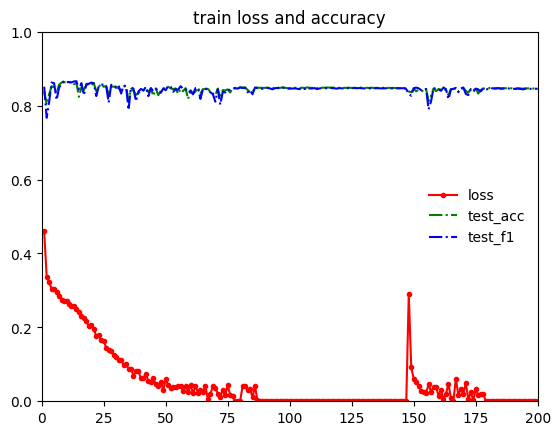

In [46]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [47]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + '2layer3linear.xlsx')

### 两个线性层

In [31]:
import time
from tqdm import tqdm

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, y = [v.to(device) for v in data]
        l = loss(net(X), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [00:01<00:00, 292.84it/s]


epoch 1, loss 0.446, train_acc 0.858, train_f1 0.859, test_acc 0.848, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.94it/s]


epoch 2, loss 0.345, train_acc 0.862, train_f1 0.851, test_acc 0.843, test_f1 0.829, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.10it/s]


epoch 3, loss 0.315, train_acc 0.815, train_f1 0.781, test_acc 0.796, test_f1 0.755, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.40it/s]


epoch 4, loss 0.310, train_acc 0.885, train_f1 0.888, test_acc 0.862, test_f1 0.866, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.67it/s]


epoch 5, loss 0.294, train_acc 0.873, train_f1 0.882, test_acc 0.852, test_f1 0.861, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 258.07it/s]


epoch 6, loss 0.285, train_acc 0.882, train_f1 0.875, test_acc 0.851, test_f1 0.840, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 283.71it/s]


epoch 7, loss 0.279, train_acc 0.888, train_f1 0.892, test_acc 0.859, test_f1 0.864, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.00it/s]


epoch 8, loss 0.278, train_acc 0.897, train_f1 0.899, test_acc 0.866, test_f1 0.869, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 332.49it/s]


epoch 9, loss 0.273, train_acc 0.886, train_f1 0.892, test_acc 0.856, test_f1 0.865, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.15it/s]


epoch 10, loss 0.261, train_acc 0.892, train_f1 0.886, test_acc 0.854, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.84it/s]


epoch 11, loss 0.260, train_acc 0.899, train_f1 0.903, test_acc 0.863, test_f1 0.868, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.19it/s]


epoch 12, loss 0.255, train_acc 0.842, train_f1 0.861, test_acc 0.821, test_f1 0.843, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.84it/s]


epoch 13, loss 0.250, train_acc 0.909, train_f1 0.909, test_acc 0.865, test_f1 0.866, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.65it/s]


epoch 14, loss 0.247, train_acc 0.906, train_f1 0.909, test_acc 0.863, test_f1 0.867, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.37it/s]


epoch 15, loss 0.246, train_acc 0.907, train_f1 0.903, test_acc 0.858, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 256.37it/s]


epoch 16, loss 0.231, train_acc 0.916, train_f1 0.916, test_acc 0.864, test_f1 0.865, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 301.53it/s]


epoch 17, loss 0.231, train_acc 0.897, train_f1 0.903, test_acc 0.853, test_f1 0.863, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 264.23it/s]


epoch 18, loss 0.228, train_acc 0.920, train_f1 0.920, test_acc 0.863, test_f1 0.862, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 264.04it/s]


epoch 19, loss 0.221, train_acc 0.925, train_f1 0.923, test_acc 0.861, test_f1 0.857, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 334.28it/s]


epoch 20, loss 0.209, train_acc 0.926, train_f1 0.927, test_acc 0.865, test_f1 0.867, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.89it/s]


epoch 21, loss 0.204, train_acc 0.914, train_f1 0.909, test_acc 0.849, test_f1 0.839, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.37it/s]


epoch 22, loss 0.196, train_acc 0.929, train_f1 0.929, test_acc 0.860, test_f1 0.861, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.32it/s]


epoch 23, loss 0.194, train_acc 0.929, train_f1 0.931, test_acc 0.857, test_f1 0.860, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.39it/s]


epoch 24, loss 0.187, train_acc 0.941, train_f1 0.940, test_acc 0.858, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.10it/s]


epoch 25, loss 0.175, train_acc 0.926, train_f1 0.923, test_acc 0.849, test_f1 0.839, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.02it/s]


epoch 26, loss 0.168, train_acc 0.933, train_f1 0.929, test_acc 0.847, test_f1 0.837, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.00it/s]


epoch 27, loss 0.159, train_acc 0.935, train_f1 0.937, test_acc 0.851, test_f1 0.860, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.97it/s]


epoch 28, loss 0.149, train_acc 0.950, train_f1 0.951, test_acc 0.858, test_f1 0.860, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.56it/s]


epoch 29, loss 0.141, train_acc 0.949, train_f1 0.950, test_acc 0.856, test_f1 0.857, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.15it/s]


epoch 30, loss 0.141, train_acc 0.960, train_f1 0.961, test_acc 0.857, test_f1 0.856, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.78it/s]


epoch 31, loss 0.127, train_acc 0.967, train_f1 0.968, test_acc 0.858, test_f1 0.860, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.67it/s]


epoch 32, loss 0.122, train_acc 0.967, train_f1 0.967, test_acc 0.854, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 335.99it/s]


epoch 33, loss 0.114, train_acc 0.965, train_f1 0.964, test_acc 0.854, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.59it/s]


epoch 34, loss 0.105, train_acc 0.963, train_f1 0.964, test_acc 0.855, test_f1 0.860, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.54it/s]


epoch 35, loss 0.102, train_acc 0.960, train_f1 0.959, test_acc 0.844, test_f1 0.833, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.74it/s]


epoch 36, loss 0.092, train_acc 0.971, train_f1 0.970, test_acc 0.846, test_f1 0.837, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.03it/s]


epoch 37, loss 0.082, train_acc 0.981, train_f1 0.980, test_acc 0.851, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.71it/s]


epoch 38, loss 0.077, train_acc 0.968, train_f1 0.969, test_acc 0.851, test_f1 0.858, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.71it/s]


epoch 39, loss 0.076, train_acc 0.985, train_f1 0.985, test_acc 0.853, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 391.41it/s]


epoch 40, loss 0.065, train_acc 0.957, train_f1 0.955, test_acc 0.831, test_f1 0.815, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 440.75it/s]


epoch 41, loss 0.062, train_acc 0.994, train_f1 0.994, test_acc 0.851, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.13it/s]


epoch 42, loss 0.059, train_acc 0.961, train_f1 0.959, test_acc 0.833, test_f1 0.817, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.88it/s]


epoch 43, loss 0.045, train_acc 0.994, train_f1 0.994, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.08it/s]


epoch 44, loss 0.039, train_acc 0.983, train_f1 0.984, test_acc 0.845, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.72it/s]


epoch 45, loss 0.047, train_acc 0.979, train_f1 0.979, test_acc 0.844, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.05it/s]


epoch 46, loss 0.045, train_acc 0.992, train_f1 0.992, test_acc 0.848, test_f1 0.841, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.58it/s]


epoch 47, loss 0.030, train_acc 0.992, train_f1 0.991, test_acc 0.849, test_f1 0.842, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.35it/s]


epoch 48, loss 0.027, train_acc 0.976, train_f1 0.975, test_acc 0.835, test_f1 0.822, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.25it/s]


epoch 49, loss 0.029, train_acc 0.998, train_f1 0.998, test_acc 0.850, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.06it/s]


epoch 50, loss 0.022, train_acc 0.966, train_f1 0.965, test_acc 0.824, test_f1 0.805, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.79it/s]


epoch 51, loss 0.021, train_acc 0.960, train_f1 0.959, test_acc 0.827, test_f1 0.809, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.95it/s]


epoch 52, loss 0.033, train_acc 0.999, train_f1 0.999, test_acc 0.851, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.07it/s]


epoch 53, loss 0.014, train_acc 0.993, train_f1 0.993, test_acc 0.843, test_f1 0.836, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.80it/s]


epoch 54, loss 0.018, train_acc 0.966, train_f1 0.967, test_acc 0.838, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.53it/s]


epoch 55, loss 0.015, train_acc 0.998, train_f1 0.998, test_acc 0.847, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.18it/s]


epoch 56, loss 0.012, train_acc 1.000, train_f1 1.000, test_acc 0.850, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.36it/s]


epoch 57, loss 0.006, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.65it/s]


epoch 58, loss 0.036, train_acc 0.997, train_f1 0.997, test_acc 0.846, test_f1 0.838, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.76it/s]


epoch 59, loss 0.009, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.65it/s]


epoch 60, loss 0.007, train_acc 0.998, train_f1 0.998, test_acc 0.847, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.36it/s]


epoch 61, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.847, test_f1 0.840, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 361.08it/s]


epoch 62, loss 0.004, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.57it/s]


epoch 63, loss 0.044, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.46it/s]


epoch 64, loss 0.010, train_acc 0.999, train_f1 0.999, test_acc 0.846, test_f1 0.838, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.96it/s]


epoch 65, loss 0.009, train_acc 1.000, train_f1 1.000, test_acc 0.850, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 362.36it/s]


epoch 66, loss 0.006, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.48it/s]


epoch 67, loss 0.007, train_acc 1.000, train_f1 1.000, test_acc 0.848, test_f1 0.840, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.46it/s]


epoch 68, loss 0.017, train_acc 1.000, train_f1 1.000, test_acc 0.846, test_f1 0.843, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.13it/s]


epoch 69, loss 0.006, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.04it/s]


epoch 70, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.15it/s]


epoch 71, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.66it/s]


epoch 72, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.73it/s]


epoch 73, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.850, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.19it/s]


epoch 74, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.849, test_f1 0.844, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.05it/s]


epoch 75, loss 0.030, train_acc 0.995, train_f1 0.995, test_acc 0.849, test_f1 0.845, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.10it/s]


epoch 76, loss 0.014, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.855, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.43it/s]


epoch 77, loss 0.006, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.855, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.94it/s]


epoch 78, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.83it/s]


epoch 79, loss 0.004, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.76it/s]


epoch 80, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.59it/s]


epoch 81, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 335.36it/s]


epoch 82, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.18it/s]


epoch 83, loss 0.038, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.40it/s]


epoch 84, loss 0.007, train_acc 1.000, train_f1 1.000, test_acc 0.850, test_f1 0.846, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.45it/s]


epoch 85, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.37it/s]


epoch 86, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.54it/s]


epoch 87, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.79it/s]


epoch 88, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.50it/s]


epoch 89, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.61it/s]


epoch 90, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.05it/s]


epoch 91, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.68it/s]


epoch 92, loss 0.039, train_acc 0.993, train_f1 0.993, test_acc 0.844, test_f1 0.839, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 332.12it/s]


epoch 93, loss 0.012, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.50it/s]


epoch 94, loss 0.004, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.14it/s]


epoch 95, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.44it/s]


epoch 96, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.67it/s]


epoch 97, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.11it/s]


epoch 98, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.52it/s]


epoch 99, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.99it/s]


epoch 100, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.850, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.07it/s]


epoch 101, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.20it/s]


epoch 102, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.78it/s]


epoch 103, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.65it/s]


epoch 104, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.55it/s]


epoch 105, loss 0.042, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.62it/s]


epoch 106, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.67it/s]


epoch 107, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.80it/s]


epoch 108, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.60it/s]


epoch 109, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.01it/s]


epoch 110, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.57it/s]


epoch 111, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.55it/s]


epoch 112, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.855, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.94it/s]


epoch 113, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.29it/s]


epoch 114, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.09it/s]


epoch 115, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.81it/s]


epoch 116, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.59it/s]


epoch 117, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.35it/s]


epoch 118, loss 0.036, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.95it/s]


epoch 119, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.51it/s]


epoch 120, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.91it/s]


epoch 121, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.74it/s]


epoch 122, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.00it/s]


epoch 123, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.857, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.96it/s]


epoch 124, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.57it/s]


epoch 125, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.95it/s]


epoch 126, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.89it/s]


epoch 127, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.856, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.97it/s]


epoch 128, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.50it/s]


epoch 129, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.40it/s]


epoch 130, loss 0.040, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.847, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.58it/s]


epoch 131, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.14it/s]


epoch 132, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 356.32it/s]


epoch 133, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 476.33it/s]


epoch 134, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 459.10it/s]


epoch 135, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 1 seconds


100%|██████████| 391/391 [00:01<00:00, 368.65it/s]


epoch 136, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.36it/s]


epoch 137, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.06it/s]


epoch 138, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.71it/s]


epoch 139, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.04it/s]


epoch 140, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.37it/s]


epoch 141, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.68it/s]


epoch 142, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.40it/s]


epoch 143, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.14it/s]


epoch 144, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.90it/s]


epoch 145, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.92it/s]


epoch 146, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.24it/s]


epoch 147, loss 0.049, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.855, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 332.88it/s]


epoch 148, loss 0.004, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 389.78it/s]


epoch 149, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.854, test_f1 0.855, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.78it/s]


epoch 150, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.23it/s]


epoch 151, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.64it/s]


epoch 152, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.04it/s]


epoch 153, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.07it/s]


epoch 154, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.98it/s]


epoch 155, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.02it/s]


epoch 156, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.45it/s]


epoch 157, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 356.42it/s]


epoch 158, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.53it/s]


epoch 159, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.849, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.96it/s]


epoch 160, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.96it/s]


epoch 161, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.05it/s]


epoch 162, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.80it/s]


epoch 163, loss 0.029, train_acc 0.940, train_f1 0.943, test_acc 0.828, test_f1 0.842, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.60it/s]


epoch 164, loss 0.011, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 355.28it/s]


epoch 165, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.12it/s]


epoch 166, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.855, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.95it/s]


epoch 167, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.99it/s]


epoch 168, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.56it/s]


epoch 169, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 336.23it/s]


epoch 170, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.30it/s]


epoch 171, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.72it/s]


epoch 172, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.35it/s]


epoch 173, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.59it/s]


epoch 174, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.848, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.07it/s]


epoch 175, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.23it/s]


epoch 176, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.71it/s]


epoch 177, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.02it/s]


epoch 178, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.28it/s]


epoch 179, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.855, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 356.12it/s]


epoch 180, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.30it/s]


epoch 181, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.05it/s]


epoch 182, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.23it/s]


epoch 183, loss 0.040, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.71it/s]


epoch 184, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 358.72it/s]


epoch 185, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.62it/s]


epoch 186, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.21it/s]


epoch 187, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.94it/s]


epoch 188, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 356.60it/s]


epoch 189, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.37it/s]


epoch 190, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 355.25it/s]


epoch 191, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.60it/s]


epoch 192, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.93it/s]


epoch 193, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 360.95it/s]


epoch 194, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.854, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 359.54it/s]


epoch 195, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.48it/s]


epoch 196, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.853, test_f1 0.853, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.44it/s]


epoch 197, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.04it/s]


epoch 198, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.851, test_f1 0.850, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.22it/s]


epoch 199, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.851, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.61it/s]


epoch 200, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.852, test_f1 0.852, taking 2 seconds
Training is finished.
训练损失:0.000, 训练集准确率:1.000, 训练集f1:1.000, 测试集准确率:0.852, 测试集f1:0.852, 在设备cuda上训练200周期, 耗时355 s


In [32]:
print(f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

测试集最佳准确率: 0.866,
测试集最佳F1分数: 0.869


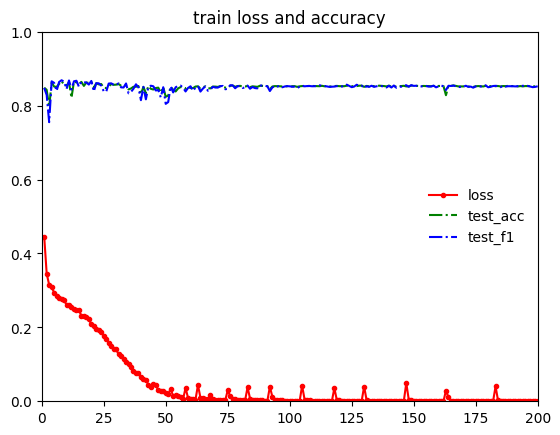

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [36]:
import pandas as pd

result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + '/2layer2linear.xlsx')

## 用第三层注意力块的输出做训练

### 三个线性层

In [4]:
dataset = load_dataset('imdb/dataset')
train_array = np.load('imdb/3layer_train_text_embedding.npy')
y_train = torch.tensor(dataset['train']['label'])

test_array = np.load('imdb/3layer_test_text_embedding.npy')
y_test = torch.tensor(dataset['test']['label'])

Using custom data configuration dataset-149a5533f7acd3e8
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/dataset-149a5533f7acd3e8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
train_set = ImdbDataset(train_array, y_train)
test_set = ImdbDataset(test_array, y_test)
batch_size = 64
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

In [8]:
net = NetForImdb(num_class=2)
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

for m in net.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

13,117,442 training parameters.


In [10]:
# 文件保存路径, 实验超参数
file_path = "/root/autodl-tmp/dcformer/imdb/output"
lr, num_epochs, device = 5e-3, 400, torch.device('cuda')
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.Adam(net.parameters())
net.to(device)

NetForImdb(
  (layer): Sequential(
    (0): Linear(in_features=2560, out_features=2560, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2560, out_features=2560, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [11]:
import time
from tqdm import tqdm

# 13,117,442 total parameters.
num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, y = [v.to(device) for v in data]
        l = loss(net(X), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [00:01<00:00, 230.88it/s]


epoch 1, loss 4.048, train_acc 0.847, train_f1 0.835, test_acc 0.810, test_f1 0.832, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.72it/s]


epoch 2, loss 0.347, train_acc 0.869, train_f1 0.860, test_acc 0.794, test_f1 0.755, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.96it/s]


epoch 3, loss 0.332, train_acc 0.877, train_f1 0.872, test_acc 0.713, test_f1 0.607, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.92it/s]


epoch 4, loss 0.311, train_acc 0.889, train_f1 0.888, test_acc 0.662, test_f1 0.497, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.44it/s]


epoch 5, loss 0.298, train_acc 0.891, train_f1 0.890, test_acc 0.631, test_f1 0.421, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.80it/s]


epoch 6, loss 0.288, train_acc 0.888, train_f1 0.886, test_acc 0.735, test_f1 0.650, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 282.53it/s]


epoch 7, loss 0.279, train_acc 0.895, train_f1 0.892, test_acc 0.675, test_f1 0.524, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 304.48it/s]


epoch 8, loss 0.278, train_acc 0.899, train_f1 0.897, test_acc 0.688, test_f1 0.553, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 267.79it/s]


epoch 9, loss 0.261, train_acc 0.882, train_f1 0.891, test_acc 0.789, test_f1 0.746, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.28it/s]


epoch 10, loss 0.260, train_acc 0.910, train_f1 0.912, test_acc 0.765, test_f1 0.712, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.47it/s]


epoch 11, loss 0.251, train_acc 0.913, train_f1 0.913, test_acc 0.829, test_f1 0.819, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.75it/s]


epoch 12, loss 0.244, train_acc 0.902, train_f1 0.905, test_acc 0.773, test_f1 0.718, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.05it/s]


epoch 13, loss 0.233, train_acc 0.915, train_f1 0.918, test_acc 0.792, test_f1 0.757, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.14it/s]


epoch 14, loss 0.222, train_acc 0.903, train_f1 0.909, test_acc 0.721, test_f1 0.631, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.62it/s]


epoch 15, loss 0.215, train_acc 0.922, train_f1 0.925, test_acc 0.804, test_f1 0.779, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.80it/s]


epoch 16, loss 0.212, train_acc 0.917, train_f1 0.918, test_acc 0.642, test_f1 0.446, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 215.50it/s]


epoch 17, loss 0.210, train_acc 0.870, train_f1 0.854, test_acc 0.644, test_f1 0.454, taking 3 seconds


100%|██████████| 391/391 [00:01<00:00, 198.91it/s]


epoch 18, loss 0.200, train_acc 0.928, train_f1 0.927, test_acc 0.806, test_f1 0.801, taking 3 seconds


100%|██████████| 391/391 [00:01<00:00, 243.30it/s]


epoch 19, loss 0.194, train_acc 0.942, train_f1 0.942, test_acc 0.764, test_f1 0.707, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 249.41it/s]


epoch 20, loss 0.185, train_acc 0.938, train_f1 0.936, test_acc 0.607, test_f1 0.360, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.19it/s]


epoch 21, loss 0.178, train_acc 0.912, train_f1 0.905, test_acc 0.748, test_f1 0.686, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.26it/s]


epoch 22, loss 0.176, train_acc 0.924, train_f1 0.919, test_acc 0.819, test_f1 0.811, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.53it/s]


epoch 23, loss 0.157, train_acc 0.950, train_f1 0.951, test_acc 0.800, test_f1 0.827, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.46it/s]


epoch 24, loss 0.161, train_acc 0.940, train_f1 0.942, test_acc 0.754, test_f1 0.694, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.20it/s]


epoch 25, loss 0.142, train_acc 0.958, train_f1 0.958, test_acc 0.746, test_f1 0.688, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.77it/s]


epoch 26, loss 0.141, train_acc 0.950, train_f1 0.948, test_acc 0.733, test_f1 0.654, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.93it/s]


epoch 27, loss 0.132, train_acc 0.939, train_f1 0.941, test_acc 0.718, test_f1 0.639, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.39it/s]


epoch 28, loss 0.117, train_acc 0.957, train_f1 0.958, test_acc 0.746, test_f1 0.686, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 363.12it/s]


epoch 29, loss 0.113, train_acc 0.951, train_f1 0.951, test_acc 0.608, test_f1 0.364, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 359.13it/s]


epoch 30, loss 0.119, train_acc 0.942, train_f1 0.939, test_acc 0.659, test_f1 0.498, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.93it/s]


epoch 31, loss 0.135, train_acc 0.960, train_f1 0.959, test_acc 0.700, test_f1 0.596, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 363.23it/s]


epoch 32, loss 0.096, train_acc 0.972, train_f1 0.972, test_acc 0.680, test_f1 0.546, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 366.31it/s]


epoch 33, loss 0.098, train_acc 0.976, train_f1 0.976, test_acc 0.702, test_f1 0.598, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 470.56it/s]


epoch 34, loss 0.092, train_acc 0.977, train_f1 0.977, test_acc 0.680, test_f1 0.547, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 474.36it/s]


epoch 35, loss 0.089, train_acc 0.950, train_f1 0.948, test_acc 0.656, test_f1 0.490, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 472.74it/s]


epoch 36, loss 0.088, train_acc 0.963, train_f1 0.964, test_acc 0.701, test_f1 0.593, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 427.64it/s]


epoch 37, loss 0.081, train_acc 0.898, train_f1 0.887, test_acc 0.732, test_f1 0.647, taking 1 seconds


100%|██████████| 391/391 [00:01<00:00, 353.17it/s]


epoch 38, loss 0.082, train_acc 0.965, train_f1 0.963, test_acc 0.737, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.67it/s]


epoch 39, loss 0.079, train_acc 0.981, train_f1 0.981, test_acc 0.778, test_f1 0.745, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 356.36it/s]


epoch 40, loss 0.073, train_acc 0.966, train_f1 0.966, test_acc 0.792, test_f1 0.810, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.19it/s]


epoch 41, loss 0.069, train_acc 0.978, train_f1 0.977, test_acc 0.768, test_f1 0.726, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.36it/s]


epoch 42, loss 0.069, train_acc 0.978, train_f1 0.978, test_acc 0.716, test_f1 0.772, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 355.92it/s]


epoch 43, loss 0.072, train_acc 0.981, train_f1 0.980, test_acc 0.646, test_f1 0.737, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 355.49it/s]


epoch 44, loss 0.059, train_acc 0.985, train_f1 0.985, test_acc 0.599, test_f1 0.712, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 355.91it/s]


epoch 45, loss 0.065, train_acc 0.988, train_f1 0.988, test_acc 0.673, test_f1 0.748, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.96it/s]


epoch 46, loss 0.070, train_acc 0.992, train_f1 0.992, test_acc 0.594, test_f1 0.709, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.10it/s]


epoch 47, loss 0.048, train_acc 0.992, train_f1 0.992, test_acc 0.566, test_f1 0.697, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.05it/s]


epoch 48, loss 0.057, train_acc 0.990, train_f1 0.990, test_acc 0.532, test_f1 0.681, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.49it/s]


epoch 49, loss 0.057, train_acc 0.985, train_f1 0.985, test_acc 0.513, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.24it/s]


epoch 50, loss 0.049, train_acc 0.980, train_f1 0.979, test_acc 0.524, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.97it/s]


epoch 51, loss 0.052, train_acc 0.979, train_f1 0.979, test_acc 0.544, test_f1 0.686, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.59it/s]


epoch 52, loss 0.046, train_acc 0.992, train_f1 0.992, test_acc 0.527, test_f1 0.679, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.34it/s]


epoch 53, loss 0.046, train_acc 0.986, train_f1 0.986, test_acc 0.539, test_f1 0.684, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 256.60it/s]


epoch 54, loss 0.052, train_acc 0.986, train_f1 0.985, test_acc 0.516, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 252.72it/s]


epoch 55, loss 0.046, train_acc 0.988, train_f1 0.988, test_acc 0.539, test_f1 0.684, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.20it/s]


epoch 56, loss 0.048, train_acc 0.989, train_f1 0.989, test_acc 0.525, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.59it/s]


epoch 57, loss 0.036, train_acc 0.993, train_f1 0.993, test_acc 0.519, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 231.08it/s]


epoch 58, loss 0.045, train_acc 0.991, train_f1 0.991, test_acc 0.516, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 219.07it/s]


epoch 59, loss 0.038, train_acc 0.995, train_f1 0.995, test_acc 0.526, test_f1 0.678, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 283.63it/s]


epoch 60, loss 0.043, train_acc 0.980, train_f1 0.980, test_acc 0.527, test_f1 0.678, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.76it/s]


epoch 61, loss 0.046, train_acc 0.993, train_f1 0.993, test_acc 0.518, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.96it/s]


epoch 62, loss 0.048, train_acc 0.991, train_f1 0.991, test_acc 0.513, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.88it/s]


epoch 63, loss 0.048, train_acc 0.992, train_f1 0.992, test_acc 0.524, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.74it/s]


epoch 64, loss 0.042, train_acc 0.991, train_f1 0.991, test_acc 0.518, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.47it/s]


epoch 65, loss 0.044, train_acc 0.989, train_f1 0.989, test_acc 0.530, test_f1 0.680, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.34it/s]


epoch 66, loss 0.048, train_acc 0.986, train_f1 0.986, test_acc 0.516, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.05it/s]


epoch 67, loss 0.031, train_acc 0.979, train_f1 0.979, test_acc 0.517, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.37it/s]


epoch 68, loss 0.059, train_acc 0.985, train_f1 0.985, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 285.63it/s]


epoch 69, loss 0.045, train_acc 0.989, train_f1 0.989, test_acc 0.514, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.31it/s]


epoch 70, loss 0.044, train_acc 0.987, train_f1 0.988, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.10it/s]


epoch 71, loss 0.036, train_acc 0.966, train_f1 0.967, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.69it/s]


epoch 72, loss 0.033, train_acc 0.993, train_f1 0.993, test_acc 0.509, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.44it/s]


epoch 73, loss 0.038, train_acc 0.965, train_f1 0.966, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 225.61it/s]


epoch 74, loss 0.049, train_acc 0.988, train_f1 0.988, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 223.31it/s]


epoch 75, loss 0.041, train_acc 0.994, train_f1 0.994, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.87it/s]


epoch 76, loss 0.031, train_acc 0.987, train_f1 0.987, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.53it/s]


epoch 77, loss 0.043, train_acc 0.991, train_f1 0.991, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.99it/s]


epoch 78, loss 0.032, train_acc 0.997, train_f1 0.997, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.25it/s]


epoch 79, loss 0.033, train_acc 0.993, train_f1 0.993, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.17it/s]


epoch 80, loss 0.042, train_acc 0.993, train_f1 0.994, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.42it/s]


epoch 81, loss 0.042, train_acc 0.984, train_f1 0.984, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.29it/s]


epoch 82, loss 0.031, train_acc 0.974, train_f1 0.973, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.44it/s]


epoch 83, loss 0.036, train_acc 0.997, train_f1 0.997, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.89it/s]


epoch 84, loss 0.038, train_acc 0.982, train_f1 0.982, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.62it/s]


epoch 85, loss 0.032, train_acc 0.992, train_f1 0.992, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.29it/s]


epoch 86, loss 0.023, train_acc 0.989, train_f1 0.989, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 293.03it/s]


epoch 87, loss 0.018, train_acc 0.992, train_f1 0.992, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 307.39it/s]


epoch 88, loss 0.040, train_acc 0.992, train_f1 0.992, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.94it/s]


epoch 89, loss 0.033, train_acc 0.993, train_f1 0.993, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.99it/s]


epoch 90, loss 0.041, train_acc 0.996, train_f1 0.996, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.62it/s]


epoch 91, loss 0.022, train_acc 0.998, train_f1 0.998, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.71it/s]


epoch 92, loss 0.036, train_acc 0.991, train_f1 0.991, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.42it/s]


epoch 93, loss 0.020, train_acc 0.997, train_f1 0.997, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.47it/s]


epoch 94, loss 0.026, train_acc 0.999, train_f1 0.999, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.48it/s]


epoch 95, loss 0.022, train_acc 0.967, train_f1 0.968, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.58it/s]


epoch 96, loss 0.020, train_acc 0.997, train_f1 0.997, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.25it/s]


epoch 97, loss 0.024, train_acc 0.996, train_f1 0.996, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 221.30it/s]


epoch 98, loss 0.020, train_acc 0.995, train_f1 0.995, test_acc 0.502, test_f1 0.668, taking 3 seconds


100%|██████████| 391/391 [00:01<00:00, 239.92it/s]


epoch 99, loss 0.027, train_acc 0.990, train_f1 0.990, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.45it/s]


epoch 100, loss 0.033, train_acc 0.982, train_f1 0.982, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.53it/s]


epoch 101, loss 0.032, train_acc 0.998, train_f1 0.998, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.60it/s]


epoch 102, loss 0.022, train_acc 0.959, train_f1 0.957, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.94it/s]


epoch 103, loss 0.026, train_acc 0.993, train_f1 0.993, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.25it/s]


epoch 104, loss 0.041, train_acc 0.980, train_f1 0.979, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.63it/s]


epoch 105, loss 0.024, train_acc 0.999, train_f1 0.999, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.43it/s]


epoch 106, loss 0.015, train_acc 0.983, train_f1 0.983, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.17it/s]


epoch 107, loss 0.015, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.34it/s]


epoch 108, loss 0.026, train_acc 0.999, train_f1 0.999, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.59it/s]


epoch 109, loss 0.009, train_acc 0.985, train_f1 0.985, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.67it/s]


epoch 110, loss 0.015, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.46it/s]


epoch 111, loss 0.038, train_acc 0.989, train_f1 0.989, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.29it/s]


epoch 112, loss 0.044, train_acc 0.983, train_f1 0.983, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.01it/s]


epoch 113, loss 0.018, train_acc 0.994, train_f1 0.994, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.11it/s]


epoch 114, loss 0.031, train_acc 0.998, train_f1 0.998, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.84it/s]


epoch 115, loss 0.016, train_acc 0.993, train_f1 0.993, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.76it/s]


epoch 116, loss 0.020, train_acc 0.991, train_f1 0.991, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.87it/s]


epoch 117, loss 0.020, train_acc 0.993, train_f1 0.993, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.70it/s]


epoch 118, loss 0.032, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.19it/s]


epoch 119, loss 0.005, train_acc 0.984, train_f1 0.984, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.45it/s]


epoch 120, loss 0.049, train_acc 0.988, train_f1 0.988, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.40it/s]


epoch 121, loss 0.026, train_acc 0.995, train_f1 0.995, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.32it/s]


epoch 122, loss 0.020, train_acc 0.998, train_f1 0.998, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.35it/s]


epoch 123, loss 0.018, train_acc 0.999, train_f1 0.999, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.03it/s]


epoch 124, loss 0.048, train_acc 0.993, train_f1 0.993, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.34it/s]


epoch 125, loss 0.033, train_acc 0.990, train_f1 0.990, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.82it/s]


epoch 126, loss 0.035, train_acc 0.993, train_f1 0.993, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.02it/s]


epoch 127, loss 0.024, train_acc 0.992, train_f1 0.992, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.33it/s]


epoch 128, loss 0.023, train_acc 0.996, train_f1 0.996, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.84it/s]


epoch 129, loss 0.027, train_acc 0.995, train_f1 0.995, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.26it/s]


epoch 130, loss 0.016, train_acc 0.995, train_f1 0.995, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.26it/s]


epoch 131, loss 0.010, train_acc 0.998, train_f1 0.998, test_acc 0.509, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.81it/s]


epoch 132, loss 0.019, train_acc 0.997, train_f1 0.997, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.27it/s]


epoch 133, loss 0.037, train_acc 0.995, train_f1 0.995, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.23it/s]


epoch 134, loss 0.009, train_acc 0.999, train_f1 0.999, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 264.63it/s]


epoch 135, loss 0.014, train_acc 0.971, train_f1 0.971, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.89it/s]


epoch 136, loss 0.021, train_acc 0.987, train_f1 0.987, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.25it/s]


epoch 137, loss 0.034, train_acc 0.990, train_f1 0.990, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.37it/s]


epoch 138, loss 0.015, train_acc 0.993, train_f1 0.993, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.23it/s]


epoch 139, loss 0.002, train_acc 0.998, train_f1 0.998, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.76it/s]


epoch 140, loss 0.034, train_acc 0.991, train_f1 0.991, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.12it/s]


epoch 141, loss 0.009, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.61it/s]


epoch 142, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.58it/s]


epoch 143, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.33it/s]


epoch 144, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.55it/s]


epoch 145, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.11it/s]


epoch 146, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.28it/s]


epoch 147, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.73it/s]


epoch 148, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.86it/s]


epoch 149, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.67it/s]


epoch 150, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.04it/s]


epoch 151, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.87it/s]


epoch 152, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.61it/s]


epoch 153, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.39it/s]


epoch 154, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.10it/s]


epoch 155, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.68it/s]


epoch 156, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.56it/s]


epoch 157, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.07it/s]


epoch 158, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.45it/s]


epoch 159, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.58it/s]


epoch 160, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.43it/s]


epoch 161, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.41it/s]


epoch 162, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.89it/s]


epoch 163, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.64it/s]


epoch 164, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.83it/s]


epoch 165, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.42it/s]


epoch 166, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.24it/s]


epoch 167, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.60it/s]


epoch 168, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.14it/s]


epoch 169, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.47it/s]


epoch 170, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.61it/s]


epoch 171, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.25it/s]


epoch 172, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.87it/s]


epoch 173, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.85it/s]


epoch 174, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.80it/s]


epoch 175, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.05it/s]


epoch 176, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.45it/s]


epoch 177, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.46it/s]


epoch 178, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.33it/s]


epoch 179, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.36it/s]


epoch 180, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.42it/s]


epoch 181, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.37it/s]


epoch 182, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.52it/s]


epoch 183, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.31it/s]


epoch 184, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.37it/s]


epoch 185, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.26it/s]


epoch 186, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.49it/s]


epoch 187, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.15it/s]


epoch 188, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.53it/s]


epoch 189, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.04it/s]


epoch 190, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.90it/s]


epoch 191, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.509, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.07it/s]


epoch 192, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.95it/s]


epoch 193, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.74it/s]


epoch 194, loss 0.119, train_acc 0.891, train_f1 0.890, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.71it/s]


epoch 195, loss 0.159, train_acc 0.958, train_f1 0.957, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.81it/s]


epoch 196, loss 0.095, train_acc 0.973, train_f1 0.973, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.13it/s]


epoch 197, loss 0.075, train_acc 0.978, train_f1 0.978, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.09it/s]


epoch 198, loss 0.067, train_acc 0.978, train_f1 0.978, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.09it/s]


epoch 199, loss 0.056, train_acc 0.975, train_f1 0.975, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.63it/s]


epoch 200, loss 0.045, train_acc 0.984, train_f1 0.984, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.94it/s]


epoch 201, loss 0.051, train_acc 0.987, train_f1 0.987, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.29it/s]


epoch 202, loss 0.036, train_acc 0.988, train_f1 0.988, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.99it/s]


epoch 203, loss 0.048, train_acc 0.980, train_f1 0.980, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.30it/s]


epoch 204, loss 0.042, train_acc 0.983, train_f1 0.984, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.80it/s]


epoch 205, loss 0.041, train_acc 0.992, train_f1 0.992, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.47it/s]


epoch 206, loss 0.050, train_acc 0.996, train_f1 0.996, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 261.99it/s]


epoch 207, loss 0.039, train_acc 0.995, train_f1 0.995, test_acc 0.509, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 235.11it/s]


epoch 208, loss 0.042, train_acc 0.993, train_f1 0.993, test_acc 0.513, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.38it/s]


epoch 209, loss 0.028, train_acc 0.959, train_f1 0.959, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.48it/s]


epoch 210, loss 0.025, train_acc 0.994, train_f1 0.994, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.65it/s]


epoch 211, loss 0.036, train_acc 0.979, train_f1 0.979, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.43it/s]


epoch 212, loss 0.029, train_acc 0.990, train_f1 0.990, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.47it/s]


epoch 213, loss 0.051, train_acc 0.997, train_f1 0.997, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.60it/s]


epoch 214, loss 0.023, train_acc 0.996, train_f1 0.996, test_acc 0.509, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.10it/s]


epoch 215, loss 0.031, train_acc 0.981, train_f1 0.981, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.38it/s]


epoch 216, loss 0.031, train_acc 0.998, train_f1 0.998, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.90it/s]


epoch 217, loss 0.029, train_acc 0.992, train_f1 0.992, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.93it/s]


epoch 218, loss 0.031, train_acc 0.990, train_f1 0.990, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.64it/s]


epoch 219, loss 0.024, train_acc 0.999, train_f1 0.999, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.45it/s]


epoch 220, loss 0.028, train_acc 0.997, train_f1 0.997, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.50it/s]


epoch 221, loss 0.007, train_acc 0.972, train_f1 0.973, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.74it/s]


epoch 222, loss 0.038, train_acc 0.978, train_f1 0.978, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.98it/s]


epoch 223, loss 0.012, train_acc 0.992, train_f1 0.992, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.51it/s]


epoch 224, loss 0.035, train_acc 0.994, train_f1 0.994, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.11it/s]


epoch 225, loss 0.019, train_acc 0.991, train_f1 0.991, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.09it/s]


epoch 226, loss 0.016, train_acc 0.999, train_f1 0.999, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.64it/s]


epoch 227, loss 0.015, train_acc 0.988, train_f1 0.988, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.42it/s]


epoch 228, loss 0.034, train_acc 0.993, train_f1 0.993, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.56it/s]


epoch 229, loss 0.008, train_acc 0.995, train_f1 0.995, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.66it/s]


epoch 230, loss 0.033, train_acc 0.999, train_f1 0.999, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.03it/s]


epoch 231, loss 0.017, train_acc 0.988, train_f1 0.988, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.36it/s]


epoch 232, loss 0.021, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.97it/s]


epoch 233, loss 0.014, train_acc 0.983, train_f1 0.982, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.11it/s]


epoch 234, loss 0.021, train_acc 0.998, train_f1 0.998, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.04it/s]


epoch 235, loss 0.011, train_acc 0.995, train_f1 0.995, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.49it/s]


epoch 236, loss 0.030, train_acc 0.986, train_f1 0.986, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.03it/s]


epoch 237, loss 0.014, train_acc 0.991, train_f1 0.991, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.15it/s]


epoch 238, loss 0.032, train_acc 0.992, train_f1 0.992, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.08it/s]


epoch 239, loss 0.017, train_acc 0.998, train_f1 0.998, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.42it/s]


epoch 240, loss 0.002, train_acc 0.999, train_f1 0.999, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.40it/s]


epoch 241, loss 0.020, train_acc 1.000, train_f1 1.000, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.85it/s]


epoch 242, loss 0.058, train_acc 0.978, train_f1 0.978, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.46it/s]


epoch 243, loss 0.037, train_acc 0.997, train_f1 0.997, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 262.63it/s]


epoch 244, loss 0.030, train_acc 0.993, train_f1 0.993, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 265.76it/s]


epoch 245, loss 0.025, train_acc 0.999, train_f1 0.999, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.81it/s]


epoch 246, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.93it/s]


epoch 247, loss 0.051, train_acc 0.982, train_f1 0.982, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.22it/s]


epoch 248, loss 0.035, train_acc 0.984, train_f1 0.984, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.52it/s]


epoch 249, loss 0.032, train_acc 0.993, train_f1 0.993, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.36it/s]


epoch 250, loss 0.009, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.92it/s]


epoch 251, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.67it/s]


epoch 252, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.04it/s]


epoch 253, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.87it/s]


epoch 254, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.72it/s]


epoch 255, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.20it/s]


epoch 256, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.03it/s]


epoch 257, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.80it/s]


epoch 258, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.77it/s]


epoch 259, loss 0.122, train_acc 0.989, train_f1 0.989, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.85it/s]


epoch 260, loss 0.019, train_acc 0.999, train_f1 0.999, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.98it/s]


epoch 261, loss 0.014, train_acc 0.998, train_f1 0.998, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.59it/s]


epoch 262, loss 0.020, train_acc 1.000, train_f1 1.000, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.29it/s]


epoch 263, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.97it/s]


epoch 264, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.63it/s]


epoch 265, loss 0.065, train_acc 0.976, train_f1 0.976, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.06it/s]


epoch 266, loss 0.020, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.23it/s]


epoch 267, loss 0.010, train_acc 0.972, train_f1 0.971, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.03it/s]


epoch 268, loss 0.034, train_acc 0.987, train_f1 0.987, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.26it/s]


epoch 269, loss 0.003, train_acc 0.996, train_f1 0.996, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.64it/s]


epoch 270, loss 0.018, train_acc 0.997, train_f1 0.997, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.32it/s]


epoch 271, loss 0.050, train_acc 0.978, train_f1 0.979, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.47it/s]


epoch 272, loss 0.027, train_acc 0.982, train_f1 0.982, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.35it/s]


epoch 273, loss 0.019, train_acc 0.994, train_f1 0.994, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.72it/s]


epoch 274, loss 0.015, train_acc 0.972, train_f1 0.973, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.01it/s]


epoch 275, loss 0.008, train_acc 0.989, train_f1 0.989, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.73it/s]


epoch 276, loss 0.021, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 271.06it/s]


epoch 277, loss 0.001, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.98it/s]


epoch 278, loss 0.024, train_acc 0.989, train_f1 0.989, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.66it/s]


epoch 279, loss 0.021, train_acc 1.000, train_f1 1.000, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.97it/s]


epoch 280, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 269.99it/s]


epoch 281, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.35it/s]


epoch 282, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.71it/s]


epoch 283, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.17it/s]


epoch 284, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.19it/s]


epoch 285, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 286.04it/s]


epoch 286, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.44it/s]


epoch 287, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.19it/s]


epoch 288, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.45it/s]


epoch 289, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.16it/s]


epoch 290, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.53it/s]


epoch 291, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.02it/s]


epoch 292, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.00it/s]


epoch 293, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.41it/s]


epoch 294, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.59it/s]


epoch 295, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 288.39it/s]


epoch 296, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.59it/s]


epoch 297, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.509, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.83it/s]


epoch 298, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.509, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 283.82it/s]


epoch 299, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.509, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.34it/s]


epoch 300, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.03it/s]


epoch 301, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.84it/s]


epoch 302, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.08it/s]


epoch 303, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.511, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.27it/s]


epoch 304, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.511, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.24it/s]


epoch 305, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.512, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.95it/s]


epoch 306, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.512, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.55it/s]


epoch 307, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.513, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.02it/s]


epoch 308, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.513, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.94it/s]


epoch 309, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.513, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.52it/s]


epoch 310, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.514, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.94it/s]


epoch 311, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.514, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.59it/s]


epoch 312, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.514, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.55it/s]


epoch 313, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.514, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.83it/s]


epoch 314, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.515, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.62it/s]


epoch 315, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.515, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 274.35it/s]


epoch 316, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.515, test_f1 0.673, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 256.34it/s]


epoch 317, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.516, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 239.34it/s]


epoch 318, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.516, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.58it/s]


epoch 319, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.517, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 272.33it/s]


epoch 320, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.517, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.96it/s]


epoch 321, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.518, test_f1 0.674, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.73it/s]


epoch 322, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.518, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.29it/s]


epoch 323, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.518, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.21it/s]


epoch 324, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.519, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.89it/s]


epoch 325, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.519, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.02it/s]


epoch 326, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.520, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.15it/s]


epoch 327, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.520, test_f1 0.676, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.34it/s]


epoch 328, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.521, test_f1 0.676, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.19it/s]


epoch 329, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.521, test_f1 0.676, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 273.66it/s]


epoch 330, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.522, test_f1 0.676, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.04it/s]


epoch 331, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.522, test_f1 0.676, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.99it/s]


epoch 332, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.523, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.65it/s]


epoch 333, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.523, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.07it/s]


epoch 334, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.524, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 277.61it/s]


epoch 335, loss 0.000, train_acc 1.000, train_f1 1.000, test_acc 0.524, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.08it/s]


epoch 336, loss 0.228, train_acc 0.923, train_f1 0.925, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 270.81it/s]


epoch 337, loss 0.145, train_acc 0.962, train_f1 0.963, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 253.78it/s]


epoch 338, loss 0.061, train_acc 0.989, train_f1 0.989, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 282.98it/s]


epoch 339, loss 0.049, train_acc 0.978, train_f1 0.978, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 282.95it/s]


epoch 340, loss 0.043, train_acc 0.993, train_f1 0.993, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 283.59it/s]


epoch 341, loss 0.043, train_acc 0.982, train_f1 0.982, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 281.11it/s]


epoch 342, loss 0.049, train_acc 0.971, train_f1 0.971, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.05it/s]


epoch 343, loss 0.048, train_acc 0.995, train_f1 0.995, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.40it/s]


epoch 344, loss 0.040, train_acc 0.991, train_f1 0.991, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.70it/s]


epoch 345, loss 0.040, train_acc 0.975, train_f1 0.975, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 279.94it/s]


epoch 346, loss 0.077, train_acc 0.983, train_f1 0.983, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.92it/s]


epoch 347, loss 0.056, train_acc 0.990, train_f1 0.990, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 280.05it/s]


epoch 348, loss 0.032, train_acc 0.985, train_f1 0.985, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 278.73it/s]


epoch 349, loss 0.037, train_acc 0.982, train_f1 0.982, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 276.56it/s]


epoch 350, loss 0.055, train_acc 0.991, train_f1 0.991, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 275.49it/s]


epoch 351, loss 0.027, train_acc 0.962, train_f1 0.961, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 268.72it/s]


epoch 352, loss 0.046, train_acc 0.997, train_f1 0.997, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 258.19it/s]


epoch 353, loss 0.017, train_acc 0.998, train_f1 0.998, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 265.81it/s]


epoch 354, loss 0.035, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 311.46it/s]


epoch 355, loss 0.028, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 369.58it/s]


epoch 356, loss 0.024, train_acc 0.997, train_f1 0.997, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 369.07it/s]


epoch 357, loss 0.014, train_acc 0.986, train_f1 0.986, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 370.55it/s]


epoch 358, loss 0.031, train_acc 0.997, train_f1 0.997, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 484.62it/s]


epoch 359, loss 0.037, train_acc 0.998, train_f1 0.998, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 398.94it/s]


epoch 360, loss 0.033, train_acc 0.998, train_f1 0.998, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 490.20it/s]


epoch 361, loss 0.022, train_acc 0.998, train_f1 0.998, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 483.46it/s]


epoch 362, loss 0.017, train_acc 0.967, train_f1 0.966, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 487.09it/s]


epoch 363, loss 0.039, train_acc 0.991, train_f1 0.991, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.76it/s]


epoch 364, loss 0.026, train_acc 0.977, train_f1 0.978, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 488.38it/s]


epoch 365, loss 0.053, train_acc 0.991, train_f1 0.991, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 490.07it/s]


epoch 366, loss 0.027, train_acc 0.997, train_f1 0.997, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 486.95it/s]


epoch 367, loss 0.034, train_acc 0.924, train_f1 0.929, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.57it/s]


epoch 368, loss 0.039, train_acc 0.999, train_f1 0.999, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.77it/s]


epoch 369, loss 0.008, train_acc 0.974, train_f1 0.974, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 480.84it/s]


epoch 370, loss 0.024, train_acc 0.999, train_f1 0.999, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.70it/s]


epoch 371, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.08it/s]


epoch 372, loss 0.046, train_acc 0.988, train_f1 0.988, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 438.57it/s]


epoch 373, loss 0.031, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 432.49it/s]


epoch 374, loss 0.019, train_acc 0.999, train_f1 0.999, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 490.74it/s]


epoch 375, loss 0.030, train_acc 0.997, train_f1 0.997, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 485.37it/s]


epoch 376, loss 0.020, train_acc 0.985, train_f1 0.985, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 460.70it/s]


epoch 377, loss 0.023, train_acc 1.000, train_f1 1.000, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.56it/s]


epoch 378, loss 0.025, train_acc 1.000, train_f1 1.000, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 486.30it/s]


epoch 379, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 490.33it/s]


epoch 380, loss 0.024, train_acc 1.000, train_f1 1.000, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 490.51it/s]


epoch 381, loss 0.019, train_acc 0.986, train_f1 0.986, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.38it/s]


epoch 382, loss 0.005, train_acc 1.000, train_f1 1.000, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.78it/s]


epoch 383, loss 0.001, train_acc 0.999, train_f1 0.999, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 487.54it/s]


epoch 384, loss 0.050, train_acc 0.996, train_f1 0.996, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 488.05it/s]


epoch 385, loss 0.049, train_acc 0.991, train_f1 0.991, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.89it/s]


epoch 386, loss 0.046, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 487.35it/s]


epoch 387, loss 0.035, train_acc 0.995, train_f1 0.995, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 488.39it/s]


epoch 388, loss 0.028, train_acc 0.992, train_f1 0.992, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 483.87it/s]


epoch 389, loss 0.036, train_acc 0.990, train_f1 0.990, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 488.51it/s]


epoch 390, loss 0.027, train_acc 0.993, train_f1 0.993, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 483.37it/s]


epoch 391, loss 0.064, train_acc 0.982, train_f1 0.982, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 488.14it/s]


epoch 392, loss 0.044, train_acc 0.991, train_f1 0.991, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.33it/s]


epoch 393, loss 0.039, train_acc 0.993, train_f1 0.993, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 487.16it/s]


epoch 394, loss 0.048, train_acc 0.987, train_f1 0.987, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 485.00it/s]


epoch 395, loss 0.042, train_acc 0.989, train_f1 0.989, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 484.44it/s]


epoch 396, loss 0.036, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 487.07it/s]


epoch 397, loss 0.030, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 489.09it/s]


epoch 398, loss 0.028, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 485.38it/s]


epoch 399, loss 0.041, train_acc 0.982, train_f1 0.982, test_acc 0.500, test_f1 0.667, taking 1 seconds


100%|██████████| 391/391 [00:00<00:00, 488.17it/s]


epoch 400, loss 0.036, train_acc 0.987, train_f1 0.987, test_acc 0.500, test_f1 0.667, taking 1 seconds
Training is finished.
训练损失:0.036, 训练集准确率:0.987, 训练集f1:0.987, 测试集准确率:0.500, 测试集f1:0.667, 在设备cuda上训练400周期, 耗时788 s


In [12]:
print(f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

测试集最佳准确率: 0.829,
测试集最佳F1分数: 0.832


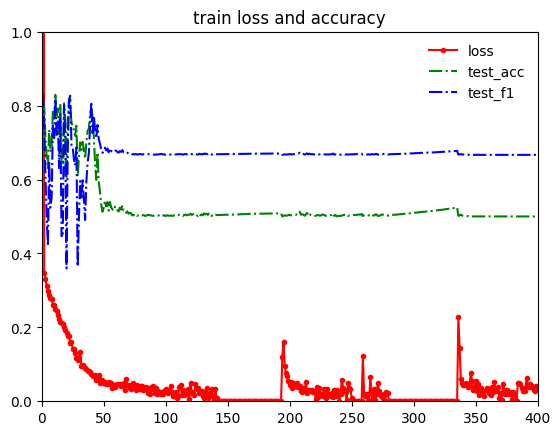

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

### 两个线性层

In [20]:
import time
from tqdm import tqdm

# 6,561,282 total parameters.
num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        X, y = [v.to(device) for v in data]
        l = loss(net(X), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [00:01<00:00, 291.33it/s]


epoch 1, loss 5.142, train_acc 0.808, train_f1 0.832, test_acc 0.783, test_f1 0.814, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.86it/s]


epoch 2, loss 1.358, train_acc 0.780, train_f1 0.725, test_acc 0.798, test_f1 0.761, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.30it/s]


epoch 3, loss 0.911, train_acc 0.845, train_f1 0.859, test_acc 0.726, test_f1 0.783, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.65it/s]


epoch 4, loss 0.615, train_acc 0.824, train_f1 0.847, test_acc 0.672, test_f1 0.752, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.48it/s]


epoch 5, loss 0.402, train_acc 0.758, train_f1 0.686, test_acc 0.844, test_f1 0.856, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.65it/s]


epoch 6, loss 0.396, train_acc 0.895, train_f1 0.897, test_acc 0.664, test_f1 0.748, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 384.65it/s]


epoch 7, loss 0.328, train_acc 0.897, train_f1 0.899, test_acc 0.655, test_f1 0.743, taking 2 seconds


100%|██████████| 391/391 [00:00<00:00, 484.68it/s]


epoch 8, loss 0.331, train_acc 0.894, train_f1 0.890, test_acc 0.796, test_f1 0.826, taking 1 seconds


100%|██████████| 391/391 [00:01<00:00, 337.17it/s]


epoch 9, loss 0.278, train_acc 0.905, train_f1 0.905, test_acc 0.785, test_f1 0.820, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 219.70it/s]


epoch 10, loss 0.299, train_acc 0.898, train_f1 0.894, test_acc 0.864, test_f1 0.868, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.71it/s]


epoch 11, loss 0.278, train_acc 0.899, train_f1 0.903, test_acc 0.792, test_f1 0.824, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.57it/s]


epoch 12, loss 0.282, train_acc 0.900, train_f1 0.895, test_acc 0.808, test_f1 0.777, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.00it/s]


epoch 13, loss 0.274, train_acc 0.907, train_f1 0.904, test_acc 0.820, test_f1 0.800, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.35it/s]


epoch 14, loss 0.274, train_acc 0.909, train_f1 0.908, test_acc 0.824, test_f1 0.810, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.13it/s]


epoch 15, loss 0.261, train_acc 0.909, train_f1 0.907, test_acc 0.819, test_f1 0.795, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.58it/s]


epoch 16, loss 0.273, train_acc 0.912, train_f1 0.912, test_acc 0.775, test_f1 0.724, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.65it/s]


epoch 17, loss 0.263, train_acc 0.856, train_f1 0.871, test_acc 0.836, test_f1 0.818, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.35it/s]


epoch 18, loss 0.264, train_acc 0.909, train_f1 0.908, test_acc 0.783, test_f1 0.739, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.99it/s]


epoch 19, loss 0.255, train_acc 0.901, train_f1 0.896, test_acc 0.749, test_f1 0.683, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.01it/s]


epoch 20, loss 0.250, train_acc 0.911, train_f1 0.912, test_acc 0.812, test_f1 0.794, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.90it/s]


epoch 21, loss 0.247, train_acc 0.899, train_f1 0.905, test_acc 0.779, test_f1 0.748, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.40it/s]


epoch 22, loss 0.237, train_acc 0.903, train_f1 0.909, test_acc 0.776, test_f1 0.760, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.40it/s]


epoch 23, loss 0.229, train_acc 0.929, train_f1 0.930, test_acc 0.792, test_f1 0.766, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.79it/s]


epoch 24, loss 0.220, train_acc 0.921, train_f1 0.925, test_acc 0.770, test_f1 0.744, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.62it/s]


epoch 25, loss 0.229, train_acc 0.926, train_f1 0.926, test_acc 0.767, test_f1 0.716, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.34it/s]


epoch 26, loss 0.202, train_acc 0.910, train_f1 0.912, test_acc 0.780, test_f1 0.739, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.84it/s]


epoch 27, loss 0.197, train_acc 0.933, train_f1 0.934, test_acc 0.812, test_f1 0.816, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.43it/s]


epoch 28, loss 0.192, train_acc 0.910, train_f1 0.903, test_acc 0.745, test_f1 0.676, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.45it/s]


epoch 29, loss 0.181, train_acc 0.936, train_f1 0.934, test_acc 0.774, test_f1 0.785, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.74it/s]


epoch 30, loss 0.171, train_acc 0.946, train_f1 0.946, test_acc 0.795, test_f1 0.810, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.22it/s]


epoch 31, loss 0.153, train_acc 0.939, train_f1 0.941, test_acc 0.750, test_f1 0.770, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.84it/s]


epoch 32, loss 0.153, train_acc 0.948, train_f1 0.950, test_acc 0.778, test_f1 0.782, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.69it/s]


epoch 33, loss 0.133, train_acc 0.961, train_f1 0.961, test_acc 0.745, test_f1 0.784, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.31it/s]


epoch 34, loss 0.138, train_acc 0.954, train_f1 0.954, test_acc 0.683, test_f1 0.751, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.68it/s]


epoch 35, loss 0.136, train_acc 0.932, train_f1 0.928, test_acc 0.790, test_f1 0.807, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.89it/s]


epoch 36, loss 0.133, train_acc 0.964, train_f1 0.964, test_acc 0.744, test_f1 0.785, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.87it/s]


epoch 37, loss 0.114, train_acc 0.964, train_f1 0.965, test_acc 0.738, test_f1 0.783, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.99it/s]


epoch 38, loss 0.112, train_acc 0.955, train_f1 0.954, test_acc 0.692, test_f1 0.751, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.40it/s]


epoch 39, loss 0.102, train_acc 0.978, train_f1 0.978, test_acc 0.696, test_f1 0.760, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.21it/s]


epoch 40, loss 0.102, train_acc 0.945, train_f1 0.947, test_acc 0.646, test_f1 0.732, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.08it/s]


epoch 41, loss 0.091, train_acc 0.959, train_f1 0.960, test_acc 0.761, test_f1 0.796, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.46it/s]


epoch 42, loss 0.111, train_acc 0.972, train_f1 0.972, test_acc 0.736, test_f1 0.782, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.99it/s]


epoch 43, loss 0.081, train_acc 0.956, train_f1 0.954, test_acc 0.684, test_f1 0.748, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.02it/s]


epoch 44, loss 0.087, train_acc 0.960, train_f1 0.961, test_acc 0.635, test_f1 0.728, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.69it/s]


epoch 45, loss 0.089, train_acc 0.979, train_f1 0.979, test_acc 0.599, test_f1 0.712, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.58it/s]


epoch 46, loss 0.065, train_acc 0.893, train_f1 0.880, test_acc 0.728, test_f1 0.775, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.00it/s]


epoch 47, loss 0.075, train_acc 0.979, train_f1 0.979, test_acc 0.594, test_f1 0.709, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.73it/s]


epoch 48, loss 0.074, train_acc 0.981, train_f1 0.980, test_acc 0.616, test_f1 0.721, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.62it/s]


epoch 49, loss 0.083, train_acc 0.965, train_f1 0.965, test_acc 0.590, test_f1 0.705, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.41it/s]


epoch 50, loss 0.056, train_acc 0.953, train_f1 0.955, test_acc 0.537, test_f1 0.683, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.89it/s]


epoch 51, loss 0.049, train_acc 0.993, train_f1 0.993, test_acc 0.558, test_f1 0.693, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.29it/s]


epoch 52, loss 0.073, train_acc 0.977, train_f1 0.978, test_acc 0.608, test_f1 0.716, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.68it/s]


epoch 53, loss 0.057, train_acc 0.987, train_f1 0.987, test_acc 0.553, test_f1 0.690, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.61it/s]


epoch 54, loss 0.058, train_acc 0.988, train_f1 0.988, test_acc 0.621, test_f1 0.723, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.81it/s]


epoch 55, loss 0.061, train_acc 0.925, train_f1 0.930, test_acc 0.548, test_f1 0.688, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.53it/s]


epoch 56, loss 0.083, train_acc 0.976, train_f1 0.976, test_acc 0.541, test_f1 0.685, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.01it/s]


epoch 57, loss 0.051, train_acc 0.992, train_f1 0.992, test_acc 0.519, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 329.68it/s]


epoch 58, loss 0.050, train_acc 0.979, train_f1 0.979, test_acc 0.523, test_f1 0.677, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.24it/s]


epoch 59, loss 0.069, train_acc 0.990, train_f1 0.990, test_acc 0.519, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.26it/s]


epoch 60, loss 0.027, train_acc 0.985, train_f1 0.985, test_acc 0.539, test_f1 0.684, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.68it/s]


epoch 61, loss 0.055, train_acc 0.992, train_f1 0.992, test_acc 0.531, test_f1 0.681, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.14it/s]


epoch 62, loss 0.046, train_acc 0.972, train_f1 0.973, test_acc 0.529, test_f1 0.680, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.51it/s]


epoch 63, loss 0.058, train_acc 0.977, train_f1 0.977, test_acc 0.518, test_f1 0.675, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.74it/s]


epoch 64, loss 0.047, train_acc 0.985, train_f1 0.985, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.29it/s]


epoch 65, loss 0.034, train_acc 0.996, train_f1 0.996, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.23it/s]


epoch 66, loss 0.065, train_acc 0.958, train_f1 0.959, test_acc 0.513, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.14it/s]


epoch 67, loss 0.067, train_acc 0.992, train_f1 0.992, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.92it/s]


epoch 68, loss 0.039, train_acc 0.979, train_f1 0.979, test_acc 0.509, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.79it/s]


epoch 69, loss 0.049, train_acc 0.971, train_f1 0.972, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.05it/s]


epoch 70, loss 0.034, train_acc 0.994, train_f1 0.994, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.66it/s]


epoch 71, loss 0.034, train_acc 0.994, train_f1 0.994, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.52it/s]


epoch 72, loss 0.039, train_acc 0.986, train_f1 0.986, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.76it/s]


epoch 73, loss 0.086, train_acc 0.974, train_f1 0.974, test_acc 0.512, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.40it/s]


epoch 74, loss 0.057, train_acc 0.990, train_f1 0.990, test_acc 0.509, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.91it/s]


epoch 75, loss 0.024, train_acc 0.990, train_f1 0.990, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 358.93it/s]


epoch 76, loss 0.027, train_acc 0.996, train_f1 0.996, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.42it/s]


epoch 77, loss 0.067, train_acc 0.993, train_f1 0.993, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.30it/s]


epoch 78, loss 0.020, train_acc 0.996, train_f1 0.996, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.23it/s]


epoch 79, loss 0.036, train_acc 0.993, train_f1 0.993, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.19it/s]


epoch 80, loss 0.024, train_acc 0.996, train_f1 0.996, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.15it/s]


epoch 81, loss 0.008, train_acc 0.999, train_f1 0.999, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.36it/s]


epoch 82, loss 0.089, train_acc 0.959, train_f1 0.960, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.93it/s]


epoch 83, loss 0.064, train_acc 0.992, train_f1 0.992, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.88it/s]


epoch 84, loss 0.028, train_acc 0.996, train_f1 0.996, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.44it/s]


epoch 85, loss 0.023, train_acc 0.989, train_f1 0.989, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.72it/s]


epoch 86, loss 0.070, train_acc 0.986, train_f1 0.987, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.61it/s]


epoch 87, loss 0.044, train_acc 0.987, train_f1 0.987, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.94it/s]


epoch 88, loss 0.035, train_acc 0.994, train_f1 0.994, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.30it/s]


epoch 89, loss 0.029, train_acc 0.990, train_f1 0.990, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.18it/s]


epoch 90, loss 0.034, train_acc 0.992, train_f1 0.992, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.77it/s]


epoch 91, loss 0.040, train_acc 0.972, train_f1 0.971, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.16it/s]


epoch 92, loss 0.021, train_acc 0.999, train_f1 0.999, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.10it/s]


epoch 93, loss 0.006, train_acc 0.997, train_f1 0.997, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.07it/s]


epoch 94, loss 0.038, train_acc 0.996, train_f1 0.996, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.47it/s]


epoch 95, loss 0.063, train_acc 0.964, train_f1 0.963, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.22it/s]


epoch 96, loss 0.036, train_acc 0.997, train_f1 0.997, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.46it/s]


epoch 97, loss 0.026, train_acc 0.985, train_f1 0.985, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 338.63it/s]


epoch 98, loss 0.026, train_acc 0.990, train_f1 0.990, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.99it/s]


epoch 99, loss 0.016, train_acc 0.998, train_f1 0.998, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.39it/s]


epoch 100, loss 0.015, train_acc 0.946, train_f1 0.949, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 330.68it/s]


epoch 101, loss 0.068, train_acc 0.994, train_f1 0.994, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.20it/s]


epoch 102, loss 0.016, train_acc 0.999, train_f1 0.999, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 333.28it/s]


epoch 103, loss 0.013, train_acc 0.999, train_f1 0.999, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.32it/s]


epoch 104, loss 0.010, train_acc 0.988, train_f1 0.988, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.32it/s]


epoch 105, loss 0.051, train_acc 0.994, train_f1 0.994, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.49it/s]


epoch 106, loss 0.013, train_acc 0.970, train_f1 0.971, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.45it/s]


epoch 107, loss 0.024, train_acc 0.982, train_f1 0.983, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.81it/s]


epoch 108, loss 0.044, train_acc 0.992, train_f1 0.992, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.20it/s]


epoch 109, loss 0.011, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.33it/s]


epoch 110, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.63it/s]


epoch 111, loss 0.002, train_acc 0.999, train_f1 0.999, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.40it/s]


epoch 112, loss 0.033, train_acc 0.917, train_f1 0.922, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.80it/s]


epoch 113, loss 0.076, train_acc 0.996, train_f1 0.996, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.72it/s]


epoch 114, loss 0.011, train_acc 0.999, train_f1 0.999, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.53it/s]


epoch 115, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.15it/s]


epoch 116, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.67it/s]


epoch 117, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.61it/s]


epoch 118, loss 0.127, train_acc 0.982, train_f1 0.982, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 354.10it/s]


epoch 119, loss 0.044, train_acc 0.992, train_f1 0.992, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.45it/s]


epoch 120, loss 0.024, train_acc 0.991, train_f1 0.991, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.16it/s]


epoch 121, loss 0.017, train_acc 0.997, train_f1 0.997, test_acc 0.511, test_f1 0.672, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.25it/s]


epoch 122, loss 0.034, train_acc 0.988, train_f1 0.988, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.81it/s]


epoch 123, loss 0.033, train_acc 0.994, train_f1 0.994, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.14it/s]


epoch 124, loss 0.031, train_acc 0.987, train_f1 0.987, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 356.32it/s]


epoch 125, loss 0.048, train_acc 0.996, train_f1 0.996, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.29it/s]


epoch 126, loss 0.009, train_acc 0.999, train_f1 0.999, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.79it/s]


epoch 127, loss 0.004, train_acc 1.000, train_f1 1.000, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.26it/s]


epoch 128, loss 0.022, train_acc 0.973, train_f1 0.972, test_acc 0.511, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.82it/s]


epoch 129, loss 0.048, train_acc 0.988, train_f1 0.988, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.72it/s]


epoch 130, loss 0.012, train_acc 0.999, train_f1 0.999, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.18it/s]


epoch 131, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.72it/s]


epoch 132, loss 0.003, train_acc 1.000, train_f1 1.000, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.65it/s]


epoch 133, loss 0.002, train_acc 1.000, train_f1 1.000, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 333.22it/s]


epoch 134, loss 0.097, train_acc 0.882, train_f1 0.869, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.72it/s]


epoch 135, loss 0.099, train_acc 0.988, train_f1 0.988, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.96it/s]


epoch 136, loss 0.030, train_acc 0.997, train_f1 0.997, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.60it/s]


epoch 137, loss 0.017, train_acc 0.995, train_f1 0.995, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.94it/s]


epoch 138, loss 0.007, train_acc 0.993, train_f1 0.993, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.98it/s]


epoch 139, loss 0.010, train_acc 0.976, train_f1 0.976, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.61it/s]


epoch 140, loss 0.065, train_acc 0.999, train_f1 0.999, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.35it/s]


epoch 141, loss 0.006, train_acc 0.999, train_f1 0.999, test_acc 0.508, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.04it/s]


epoch 142, loss 0.020, train_acc 0.995, train_f1 0.995, test_acc 0.510, test_f1 0.671, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.57it/s]


epoch 143, loss 0.004, train_acc 1.000, train_f1 1.000, test_acc 0.509, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.74it/s]


epoch 144, loss 0.007, train_acc 0.921, train_f1 0.927, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 334.78it/s]


epoch 145, loss 0.061, train_acc 0.996, train_f1 0.996, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 307.60it/s]


epoch 146, loss 0.014, train_acc 0.998, train_f1 0.998, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 358.10it/s]


epoch 147, loss 0.007, train_acc 0.999, train_f1 0.999, test_acc 0.506, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.79it/s]


epoch 148, loss 0.072, train_acc 0.970, train_f1 0.970, test_acc 0.504, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.06it/s]


epoch 149, loss 0.063, train_acc 0.988, train_f1 0.988, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.83it/s]


epoch 150, loss 0.037, train_acc 0.981, train_f1 0.981, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.59it/s]


epoch 151, loss 0.037, train_acc 0.994, train_f1 0.994, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 353.70it/s]


epoch 152, loss 0.030, train_acc 0.986, train_f1 0.986, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.83it/s]


epoch 153, loss 0.037, train_acc 0.979, train_f1 0.979, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.87it/s]


epoch 154, loss 0.025, train_acc 0.992, train_f1 0.992, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.13it/s]


epoch 155, loss 0.012, train_acc 0.997, train_f1 0.997, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.83it/s]


epoch 156, loss 0.011, train_acc 0.996, train_f1 0.996, test_acc 0.505, test_f1 0.669, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.95it/s]


epoch 157, loss 0.073, train_acc 0.984, train_f1 0.984, test_acc 0.507, test_f1 0.670, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.51it/s]


epoch 158, loss 0.036, train_acc 0.970, train_f1 0.970, test_acc 0.504, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 351.31it/s]


epoch 159, loss 0.025, train_acc 0.992, train_f1 0.992, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.40it/s]


epoch 160, loss 0.034, train_acc 0.945, train_f1 0.942, test_acc 0.503, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.24it/s]


epoch 161, loss 0.030, train_acc 0.996, train_f1 0.996, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.07it/s]


epoch 162, loss 0.020, train_acc 0.990, train_f1 0.990, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.84it/s]


epoch 163, loss 0.029, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.47it/s]


epoch 164, loss 0.037, train_acc 0.966, train_f1 0.966, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 339.05it/s]


epoch 165, loss 0.019, train_acc 0.994, train_f1 0.994, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.14it/s]


epoch 166, loss 0.020, train_acc 0.990, train_f1 0.990, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.51it/s]


epoch 167, loss 0.026, train_acc 0.995, train_f1 0.995, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.89it/s]


epoch 168, loss 0.016, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.95it/s]


epoch 169, loss 0.025, train_acc 0.991, train_f1 0.991, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.23it/s]


epoch 170, loss 0.026, train_acc 0.995, train_f1 0.995, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 336.90it/s]


epoch 171, loss 0.019, train_acc 0.980, train_f1 0.980, test_acc 0.502, test_f1 0.668, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 350.88it/s]


epoch 172, loss 0.021, train_acc 0.993, train_f1 0.993, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.03it/s]


epoch 173, loss 0.014, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.04it/s]


epoch 174, loss 0.039, train_acc 0.994, train_f1 0.994, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.93it/s]


epoch 175, loss 0.010, train_acc 0.998, train_f1 0.998, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.93it/s]


epoch 176, loss 0.008, train_acc 0.994, train_f1 0.994, test_acc 0.502, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 341.39it/s]


epoch 177, loss 0.061, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.44it/s]


epoch 178, loss 0.012, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 337.87it/s]


epoch 179, loss 0.005, train_acc 0.999, train_f1 0.999, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 342.72it/s]


epoch 180, loss 0.022, train_acc 0.993, train_f1 0.993, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.38it/s]


epoch 181, loss 0.023, train_acc 0.982, train_f1 0.982, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 343.24it/s]


epoch 182, loss 0.021, train_acc 0.998, train_f1 0.998, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.87it/s]


epoch 183, loss 0.011, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.45it/s]


epoch 184, loss 0.016, train_acc 0.995, train_f1 0.995, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 347.56it/s]


epoch 185, loss 0.051, train_acc 0.997, train_f1 0.997, test_acc 0.501, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.15it/s]


epoch 186, loss 0.009, train_acc 0.970, train_f1 0.970, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 346.95it/s]


epoch 187, loss 0.020, train_acc 0.996, train_f1 0.996, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.51it/s]


epoch 188, loss 0.046, train_acc 0.970, train_f1 0.970, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 344.61it/s]


epoch 189, loss 0.049, train_acc 0.989, train_f1 0.989, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.05it/s]


epoch 190, loss 0.025, train_acc 0.993, train_f1 0.993, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.91it/s]


epoch 191, loss 0.020, train_acc 0.992, train_f1 0.992, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.06it/s]


epoch 192, loss 0.015, train_acc 0.996, train_f1 0.996, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 345.04it/s]


epoch 193, loss 0.022, train_acc 0.997, train_f1 0.997, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 349.12it/s]


epoch 194, loss 0.034, train_acc 0.994, train_f1 0.994, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 352.57it/s]


epoch 195, loss 0.020, train_acc 0.976, train_f1 0.977, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.29it/s]


epoch 196, loss 0.029, train_acc 0.996, train_f1 0.996, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 340.06it/s]


epoch 197, loss 0.010, train_acc 0.998, train_f1 0.998, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 366.01it/s]


epoch 198, loss 0.014, train_acc 0.953, train_f1 0.952, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 358.43it/s]


epoch 199, loss 0.030, train_acc 0.999, train_f1 0.999, test_acc 0.500, test_f1 0.667, taking 2 seconds


100%|██████████| 391/391 [00:01<00:00, 348.95it/s]


epoch 200, loss 0.007, train_acc 0.999, train_f1 0.999, test_acc 0.500, test_f1 0.667, taking 2 seconds
Training is finished.
训练损失:0.007, 训练集准确率:0.999, 训练集f1:0.999, 测试集准确率:0.500, 测试集f1:0.667, 在设备cuda上训练200周期, 耗时355 s


In [21]:
print(f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

测试集最佳准确率: 0.864,
测试集最佳F1分数: 0.868


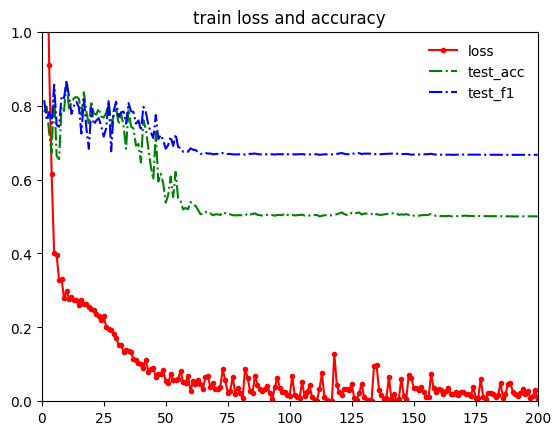

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, train_accuracy, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()